### Group Project - Group 7: Taiwo, Daniel, Sohag

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# Question Formulation
## Goal of Analysis
The initial goal of our analysis is to build a model to predict ClickThroughRate (CTR), i.e. given a user and the page he is visiting, what is the probability that he will click on a given ad? The larger goal is to build a model that will perform at scale using concepts taught in this class. 
## What questions do we seek to answer?
Some of the questions that we seek to answer are: 
<li> Which variables are most important to determine click-through rate?</li>
<li> Which algorithms produce the best score?</li>
<li> How can we scale this predictive model so that it can handle larger datasets?</li>

## Why do people perform this kind of analysis?
Click-through rate (CTR) prediction is critical to many web applications including web search, recommender systems, sponsored search, and display advertising. Search advertising, known as sponsored search, refers to advertisers identifying relevant keywords based on their product or service for advertising. When the user retrieves the keyword purchased by the advertiser, the corresponding advertisement is triggered and displayed. In the cost-per-click model, the advertiser pays the web publisher only when a user clicks their advertisements and visits the advertiser's site. The CTR prediction is defined to estimate the ratio of clicks to impressions of advertisements that will be displayed. 
## What level of performance would our model would need to achieve to be practically useful?
Based on a literature search, the model would have to have an "areaUnderROC" value of close to 75% and a logloss of 0.025 for it to be considered a high-performing model (Wang et al., 2018). Entropy or mutual information is another metric that is useful for CTR prediction algorithms. Juan et al., 2017 used a normalized log loss to measure performance of their model as well as a "Utility" metric which allows to model offline the potential change in profit due to a prediction model change.

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
trainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')
#smallRDD = sc.textFile('data/wiki_graph.txt')

In [137]:
!head -n1000 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [100]:
%%writefile Testing.txt
f1	f2	f3	f4	f5	f6	f7	f8	f9	f10	f11	f12	f13	f14	f15	f16	f17	f18	f19	f20	f21	f22	f23	f24	f25	f26	f27	f28	f29	f30	f31	f32	f33	f34	f35	f36	f37	f38	f39	f40
0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8cf07265	ae46a29d	c81688bb	f922efad	25c83c98	13718bbd	ad9fa255	0b153874	a73ee510	5282c137	e5d8af57	66a76a26	f06c53ac	1adce6ef	8ff4b403	01adbab4	1e88c74f	26b3c7a7			21c9516a		32c7478e	b34f3128		
0		-1			12824		0	0	6		0			05db9164	6c9c9cf3	2730ec9c	5400db8b	43b19349	6f6d9be8	53b5f978	0b153874	a73ee510	3b08e48b	91e8fc27	be45b877	9ff13f22	07d13a8f	06969a20	9bc7fff5	776ce399	92555263			242bb710	8ec974f4	be7c41b4	72c78f11		
0		1	2		3168		0	1	2		0			439a44a4	ad4527a2	c02372d0	d34ebbaa	43b19349	fe6b92e5	4bc6ffea	0b153874	a73ee510	3b08e48b	a4609aab	14d63538	772a00d7	07d13a8f	f9d1382e	b00d3dc9	776ce399	cdfa8259			20062612		93bad2c0	1b256e61		
1	1	4	2	0	0	0	1	0	0	1	1		0	68fd1e64	2c16a946	503b9dbc	e4dbea90	f3474129	13718bbd	38eb9cf4	1f89b562	a73ee510	547c0ffe	bc8c9f21	60ab2f07	46f42a63	07d13a8f	18231224	e6b6bdc7	e5ba7672	74ef3502			5316a17f		32c7478e	9117a34a		
0		44	4	8	19010	249	28	31	141		1		8	05db9164	d833535f	d032c263	c18be181	25c83c98	7e0ccccf	d5b6acf2	0b153874	a73ee510	2acdcf4e	086ac2d2	dfbb09fb	41a6ae00	b28479f6	e2502ec9	84898b2a	e5ba7672	42a2edb9			0014c32a		32c7478e	3b183c5c		
0		35		1	33737	21	1	2	3		1		1	05db9164	510b40a5	d03e7c24	eb1fd928	25c83c98		52283d1c	0b153874	a73ee510	015ac893	e51ddf94	951fe4a9	3516f6e6	07d13a8f	2ae4121c	8ec71479	d4bb7bd8	70d0f5f9			0e63fca0		32c7478e	0e8fe315		
0		2	632	0	56770		0	5	65		0		2	05db9164	0468d672	7ae80d0f	80d8555a	25c83c98	7e0ccccf	04277bf9	0b153874	7cc72ec2	3b08e48b	7e2c5c15	cfc86806	91a1b611	b28479f6	58251aab	146a70fd	776ce399	0b331314	21ddcdc9	5840adea	cbec39db		3a171ecb	cedad179	ea9a246c	9a556cfc
0	0	6	6	6	421	109	1	7	107	0	1		6	05db9164	9b5fd12f			4cf72387		111121f4	0b153874	a73ee510	3b08e48b	ac9c2e8f		6e2d6a15	07d13a8f	796a1a2e		d4bb7bd8	8aaa5b67					32c7478e			
1	0	-1			1465	0	17	0	4	0	4			241546e0	38a947a1	fa673455	6a14f9b9	25c83c98	fe6b92e5	1c86e0eb	1f89b562	a73ee510	e7ba2569	755e4a50	208d9687	5978055e	07d13a8f	5182f694	f8b34416	e5ba7672	e5f8f18f			f3ddd519		32c7478e	b34f3128		
1		2	11	5	10262	34	2	4	5		1		5	be589b51	287130e0	cd7a7a22	fb7334df	25c83c98		6cdb3998	361384ce	a73ee510	3ff10fb2	5874c9c9	976cbd4c	740c210d	1adce6ef	310d155b	07eb8110	07c540c4	891589e7	18259a83	a458ea53	a0ab60ca		32c7478e	a052b1ed	9b3e8820	8967c0d2
0	0	51	84	4	3633	26	1	4	8	0	1		4	5a9ed9b0	80e26c9b	97144401	5dbf0cc5	0942e0a7	13718bbd	9ce6136d	0b153874	a73ee510	2106e595	b5bb9d63	04f55317	ab04d8fe	1adce6ef	0ad47a49	2bd32e5c	3486227d	12195b22	21ddcdc9	b1252a9d	fa131867		dbb486d7	8ecc176a	e8b83407	c43c3f58
0		2	1	18	20255		0	1	1306		0		20	05db9164	bc6e3dc1	67799c69	d00d0f35	4cf72387	7e0ccccf	ca4fd8f8	64523cfa	a73ee510	3b08e48b	a0060bca	b9f28c33	22d23aac	5aebfb83	d702713a	0f655650	776ce399	3a2028fd			b426bc93		3a171ecb	2e0a0035		
1	1	987		2	105	2	1	2	2	1	1		2	68fd1e64	38d50e09	da603082	431a5096	43b19349	7e0ccccf	3f35b640	0b153874	a73ee510	3b08e48b	3d5fb018	6aaab577	94172618	07d13a8f	ee569ce2	2f03ef40	d4bb7bd8	582152eb	21ddcdc9	b1252a9d	3b203ca1		32c7478e	b21dc903	001f3601	aa5f0a15
0	0	1		0	16597	557	3	5	123	0	1		1	8cf07265	7cd19acc	77f2f2e5	d16679b9	4cf72387	fbad5c96	8fb24933	0b153874	a73ee510	0095a535	3617b5f5	9f32b866	428332cf	b28479f6	83ebd498	31ca40b6	e5ba7672	d0e5eb07			dfcfc3fa	ad3062eb	32c7478e	aee52b6f		
0	0	24	4	2	2056	12	6	10	83	0	1		2	05db9164	f0cf0024	08b45d8b	cbb5af1b	384874ce	fbad5c96	81bb0302	37e4aa92	a73ee510	175d6c71	b7094596	1c547463	1f9d2c38	1adce6ef	55dc357b	0ca69655	e5ba7672	b04e4670	21ddcdc9	b1252a9d	f3caefdd		32c7478e	4c8e5aef	ea9a246c	9593bba9
0	7	102		3	780	15	7	15	15	1	1		3	3c9d8785	b0660259	3a960356	15c92ddb	4cf72387	13718bbd	00c46cd1	0b153874	a73ee510	62cfc6bd	8cffe207	656e5413	ff5626de	ad1cc976	27b1230c	fa8d05aa	e5ba7672	5edd90de			e12ce348		c3dc6cef	49045073		
1		47		0	6399	38	19	10	143		10		6	1464facd	38a947a1	223b0e16	ca55061c	25c83c98	7e0ccccf	6933dec1	5b392875	a73ee510	3b08e48b	860c302b	156f99ef	30735474	1adce6ef	0e78291e	5fbf4a84	e5ba7672	1999bae9			deb9605d		32c7478e	e448275f		
0	0	1	80	0	1848	287	1	4	46	0	1		4	05db9164	09e68b86	13b87f72	13a91973	25c83c98	7e0ccccf	cc5ed2f1	0b153874	a73ee510	3b08e48b	081c279a	d25f00b6	9f16a973	07d13a8f	36721ddc	1746d357	d4bb7bd8	5aed7436	a153cea2	a458ea53	dd37e0d1		32c7478e	c70a58f2	e8b83407	af7ece63
0		0	14	6	7132	171	2	2	6		1		6	05db9164	38a947a1	e88a1d4c	8eb9aec7	25c83c98	fbad5c96	3fd38f3b	5b392875	a73ee510	5162b19c	7c430b79	4ac05ba7	7f0d7407	b28479f6	d1128331	ce881087	07c540c4	5d93f8ab			57d0811b		3a171ecb	1793a828		
0		9	9	17	11774		0	23	128		0		17	05db9164	08d6d899	cf59444f	60d5f5a7	25c83c98	7e0ccccf	38850d41	0b153874	a73ee510	6e7947ce	49aeb6a9	1d00cbc4	8f7e5dc7	07d13a8f	41f10449	b93ac0ad	1e88c74f	698d1c68			bf8efd4c		c7dc6720	f96a556f		
0	0	1	2		6190	84	1	27	71	0	1			5a9ed9b0	3df44d94	d032c263	c18be181	25c83c98	7e0ccccf	a0845add	0b153874	a73ee510	967857d1	e469acef	dfbb09fb	849a0a56	07d13a8f	72d05a1c	84898b2a	d4bb7bd8	e7648a8f			0014c32a	c9d4222a	3a171ecb	3b183c5c		
0		4	16		5925	2	2	0	0		1			5a9ed9b0	09e68b86	64094ddd	b0a4d1e3	25c83c98		b87f4a4a	0b153874	a73ee510	2124a520	319687c9	b51dc799	62036f49	64c94865	91126f30	1a00d73c	07c540c4	5aed7436	aa0cf899	a458ea53	c30dce78		32c7478e	3fdb382b	e8b83407	49d68486
1	0	1	20	16	1548	93	42	32	912	0	15	1	16	8cf07265	942f9a8d	a8e40bcf	0365276a	25c83c98	7e0ccccf	3f4ec687	1f89b562	a73ee510	726f00fd	c4adf918	27c604a6	85dbe138	07d13a8f	a8e962af	c449f783	27c07bd6	1f868fdd	21ddcdc9	a458ea53	7eee76d1		32c7478e	9af06ad9	9d93af03	cdfe5ab7
1	0	20	2	2	7188	170	2	3	24	0	2	0	2	68fd1e64	38a947a1	ee6e4611	30d9fc77	4cf72387	7e0ccccf	bf9d4f90	0b153874	a73ee510	b7c4dad5	81cae03e	5332e3fb	d413ef3e	07d13a8f	a6d97bf2	ec676ace	3486227d	02e8d897			b055c31b		3a171ecb	ae2cd100		
1	0	78	2	15	4311	85	4	18	230	0	3		15	68fd1e64	1287a654	5ed035c9	5b5365b2	4cf72387	6f6d9be8	1b1aa9ea	0b153874	a73ee510	c3e69838	7a3651f5	df8b1dea	95bc260c	b28479f6	ced5be3a	4cc0abe4	e5ba7672	df00d249			f520f961		32c7478e	27b60b01		
1	3	0	4	13	224	28	3	35	27	1	1		13	05db9164	90081f33	993f507e	14a74146	25c83c98	13718bbd	dc7659bd	0b153874	a73ee510	03e48276	e51ddf94	18fe7085	3516f6e6	64c94865	98995c3b	8c48eb08	e5ba7672	7181ccc8			2ed6b316		3a171ecb	abf08f1b		
1		277		3	7318	24	6	3	98		1		3	8cf07265	9adf4cf9	2e76fb61	0b1ad9da	4cf72387	fe6b92e5	75dcaaca	0b153874	a73ee510	3b08e48b	8aabdae8	9886a0a7	edcf17ce	07d13a8f	2aaebd23	338c0d09	e5ba7672	c7dbecd5			60d2d691		3a171ecb	90b6276f		
0		-1			4956		0	37	97		0			be589b51	4c2bc594	d032c263	c18be181	25c83c98	fe6b92e5	aa0d873c	0b153874	a73ee510	3b08e48b	868744ab	dfbb09fb	9dfda2b9	8ceecbc8	7ac43a46	84898b2a	776ce399	bc48b783			0014c32a		55dd3565	3b183c5c		
0	1	0	1		1427	3	16	11	50	0	2	1		05db9164	26a88120	615e3e4e	2788fed8	4cf72387	7e0ccccf	3f4ec687	0b153874	a73ee510	0e9ead52	c4adf918	f5d19c1c	85dbe138	07d13a8f	24ff9452	1034ac0d	3486227d	b486119d			63580fba		32c7478e	2a90c749		
0	4	0	55	8	859	13	4	12	13	1	1		8	05db9164	e5fb1af3	4b644986	5dbf0cc5	25c83c98		cc5ed2f1	0b153874	a73ee510	3b08e48b	facf05cc	6d89b6a5	9f16a973	cfef1c29	1e744fde	2bd32e5c	776ce399	13145934	21ddcdc9	a458ea53	1419c3fc		32c7478e	8ecc176a	e8b83407	a70a038a
1	1	259	1	1	5	1	6	1	1	1	3		1	05db9164	f3b07830	ad981000	f96c819d	25c83c98		df5c2d18	0b153874	a73ee510	8aef4905	a7b606c4	b912be9f	eae197fd	b28479f6	d27eed0e	b8b09fe6	e5ba7672	048d01f4			08ae854d		32c7478e	c657e6e5		
1	0	127	1	3	1683	19	26	17	475	0	9	0	3	05db9164	8947f767	11c9d79e	52a787c8	4cf72387	fbad5c96	18671b18	0b153874	a73ee510	ceb10289	77212bd7	79507c6b	7203f04e	07d13a8f	2c14c412	49013ffe	8efede7f	bd17c3da	f6a3e43b	a458ea53	35cd95c9	ad3062eb	c7dc6720	3fdb382b	010f6491	49d68486
0		1			23255		0	1	73		0			7e5c2ff4	d833535f	b00d1501	d16679b9	25c83c98	7e0ccccf	65c53f25	1f89b562	a73ee510	3b08e48b	ad2bc6f4	e0d76380	39ccb769	b28479f6	a733d362	1203a270	776ce399	281769c2			73d06dde		32c7478e	aee52b6f		
0	6	-1			915	40	26	33	72	1	3			9a89b36c	4f25e98b	9042c4ea	343f8ed3	25c83c98	fbad5c96	27cc0b50	0b153874	a73ee510	f364a867	7671c62f	00750e7a	1fa0660e	b28479f6	df2f73e9	4f71659c	e5ba7672	bc5a0ff7	21ddcdc9	a458ea53	706ee322	c9d4222a	bcdee96c	990a118a	001f3601	47b6f269
0	0	0	3	12	7308	97	2	21	90	0	1		12	68fd1e64	9adf4cf9	723c059c	4c942c6d	4cf72387	7e0ccccf	ce4f7f55	0b153874	a73ee510	d7026747	38f692a7	ab60a748	6e5da64f	1adce6ef	808ff1bc	c23fc7ec	e5ba7672	2a93f7c8			5dc9a057		32c7478e	90b6276f		
0	8	0	15	20	115	24	8	23	24	2	2		20	5a9ed9b0	c66fca21	78171040	373c404a	25c83c98		8ff6f5af	0b153874	a73ee510	5ba575e7	b5a9f90e	6766a7f0	949ea585	1adce6ef	8736735c	59974c9c	8efede7f	1304f63b	21ddcdc9	b1252a9d	07b2853e		32c7478e	94bde4f2	010f6491	09b76f8d
0		38	2	4	3119	149	64	48	139		6	6	4	05db9164	26a88120	d032c263	c18be181	4cf72387	fbad5c96	3f4ec687	1f89b562	a73ee510	726f00fd	c4adf918	dfbb09fb	85dbe138	07d13a8f	040ec437	84898b2a	8efede7f	57598e25			0014c32a		32c7478e	3b183c5c		
1	88	319		4	5	4	89	40	88	3	4	12	4	05db9164	08d6d899	333440d5	fc86bde0	25c83c98	fbad5c96	f00bddf8	0b153874	a73ee510	83ff688a	55795b33	1b0c8aa3	39795005	b28479f6	bffbd637	4a838997	8efede7f	bbf70d82			16e2e3b3		32c7478e	d859b4dd		
0		1	18	5	1683	80	38	5	95		5	0	5	05db9164	09e68b86	aa8c1539	85dd697c	25c83c98		2903ead3	0b153874	a73ee510	bcc8b4c6	a0a5e9d7	d8c29807	ee79db7b	1adce6ef	dcd06253	c64d548f	3486227d	63cdbb21	cf99e5de	a458ea53	5f957280		32c7478e	1793a828	e8b83407	b7d9c3bc
0		27			112878	2106	0	2	95		0			5a9ed9b0	38a947a1	2d8004c4	40ed41e5	25c83c98	7e0ccccf	4d9d55ae	5b392875	7cc72ec2	3b08e48b	55065437	ad972965	80dcea18	07d13a8f	c68ba31d	1206a8a1	d4bb7bd8	e96a7df2			54d8bb06		3a171ecb	a415643d		
0	0	-1			4894	20	1	7	20	0	1			05db9164	4c2bc594	d032c263	c18be181	43b19349	7e0ccccf	7f52e00f	0b153874	a73ee510	48a4f593	bca79aeb	dfbb09fb	5218d824	8ceecbc8	7ac43a46	84898b2a	07c540c4	bc48b783			0014c32a	c9d4222a	3a171ecb	3b183c5c		
0	0	32		1	9375		0	37	18	0	0	0	1	05db9164	d833535f	ad4b77ff	d16679b9	25c83c98	7e0ccccf	9d547ce0	5b392875	a73ee510	3b08e48b	868a9e47	a2f4e8b5	fc5dea81	b28479f6	a733d362	89052618	3486227d	281769c2			d4703ebd		32c7478e	aee52b6f		
0		6	6	15	20213	507	7	42	360		2	0	40	05db9164	0ca4b7d7	d032c263	c18be181	4cf72387	7e0ccccf	e9396c09	c8ddd494	a73ee510	3b08e48b	a0060bca	dfbb09fb	22d23aac	1adce6ef	9014f0f9	84898b2a	e5ba7672	c786d1ea			0014c32a		32c7478e	3b183c5c		
0	31	17	2	11	290	23	31	23	65	2	2		11	05db9164	4f25e98b	03280284	5214fda3	25c83c98	fbad5c96	0c41b6a1	0b153874	a73ee510	fa642b71	4ba74619	60bab41d	879fa878	07d13a8f	5be89da3	b6acbd10	e5ba7672	bc5a0ff7	fae651c5	a458ea53	3792328c	c0061c6d	423fab69	7a8e7ed6	001f3601	f159b6cb
0	1	2382	13	4	40	4	69	3	609	1	11	0	4	05db9164	38a947a1	933cc823	b1c1e580	25c83c98	fe6b92e5	002fdf0c	1f89b562	a73ee510	61f70369	a4ea009a	2562cf3c	1e9339bc	b28479f6	f5bfabbd	03dee53f	e5ba7672	b3e92443			be661a75		c7dc6720	67d37917		
0	0	190			1624	6	29	6	74	0	9			68fd1e64	c41a84c8	0a266224	759c4a2e	25c83c98		804d2f11	0b153874	a73ee510	2860ede1	1aa6cf31	99dfd83a	3b03d76e	b28479f6	e3eb97c7	62b5674b	e5ba7672	5911fc7e			28ee216d		32c7478e	590b856f		
0	0	19	8	9	1506	31	3	7	34	0	1		9	05db9164	8947f767	100a3803	ad1b5124	30903e74	7e0ccccf	bb3b7ab9	c8ddd494	a73ee510	3b08e48b	90b202b5	d377c333	3a9dafb8	b28479f6	a473257f	68d2c2b9	8efede7f	bd17c3da	e51f040f	a458ea53	79c3f011		bcdee96c	fe35ffe2	010f6491	987ea0be
1	1	30		3	116	31	1	3	3	1	1		3	5a9ed9b0	38a947a1	0f90b6d6	16b922ed	25c83c98	fbad5c96	17b47bf9	0b153874	a73ee510	3b08e48b	76120d9d	ee2d3fdb	d4384424	07d13a8f	3046a70a	81371cbc	d4bb7bd8	1bae7658			37bad455	ad3062eb	3a171ecb	9d96bacb		
0		6	2	3	2779		0	3	13		0		3	fb174e6b	47e8ab98	b009d929	c7043c4b	384874ce		646e7593	0b153874	a73ee510	3b08e48b	d05acfa9	3563ab62	969e14fd	1adce6ef	bfa6d08a	b688c8cc	8efede7f	eb4d3f8a	21ddcdc9	5840adea	2754aaf1		55dd3565	3b183c5c	f55c04b6	491eeeef
0	0	2	22	3	4687	242	6	6	183	0	1	4	3	05db9164	287130e0	c09cf4ef	bc8d1aa6	25c83c98	13718bbd	1919941b	37e4aa92	a73ee510	6c47047a	86c05043	c4bba41d	2ecea536	b28479f6	9efd8b77	ac2e5095	8efede7f	891589e7	2efde463	b1252a9d	dc4e98e3		3a171ecb	ee42de86	e8b83407	a00829e6
0		55	16	7	1696	72	2	7	95		2		7	5bfa8ab5	89ddfee8	00e2b23c	10d65c35	25c83c98	7e0ccccf	ad3508b1	5b392875	a73ee510	fc3680e8	ad757a5a	f400e021	93b18cb5	1adce6ef	34cce7d2	9e87470c	e5ba7672	5bb2ec8e	7a45f7f2	a458ea53	a13d5eab		423fab69	faf5d8b3	f0f449dd	a8cf207e
0	6	0	28	0	31	0	6	0	0	1	1		0	8cf07265	287130e0	c1ba4c5a	16fe249c	25c83c98	7e0ccccf	c1225605	985e3fcb	a73ee510	ede207dc	f29b9ed2	469027a9	7eaf6f1a	07d13a8f	10040656	8f13519e	e5ba7672	891589e7	6f3756eb	5840adea	f4095a39		c7dc6720	1793a828	e8b83407	a475662f
0	0	19	9	3	14414	1353	3	1	362	0	1	0	3	be589b51	09e68b86	4bee8a47	5031d726	25c83c98	7e0ccccf	197b4575	322e63df	a73ee510	6c47047a	48876b80	6f95f18b	e40e52ae	07d13a8f	36721ddc	3d66d729	8efede7f	5aed7436	21ddcdc9	a458ea53	3c1a8dd8		3a171ecb	3fdb382b	b9266ff0	49d68486
0		18	12	8	8965	44	2	12	57		2	0	8	05db9164	d7988e72	5eee7056	c1a3acf5	afcf7897		96825c8f	0b153874	a73ee510	bc283a64	2df02cf1	f71904ea	03232503	b28479f6	c8389df7	0db58836	07c540c4	0f2f9850	5fd56cf9	b1252a9d	96725293		32c7478e	2702453c	8b8de563	303cea07
0		1	2	0	177674		0	3	2		0	0	1	87552397	207b2d81	6e136288	4f938621	25c83c98	7e0ccccf	8025502e	6c41e35e	7cc72ec2	4072f40f	29e4ad33	64ddde07	80467802	07d13a8f	0bf0feff	0c41b634	e5ba7672	fa0643ee	21ddcdc9	b1252a9d	b4031b95		3a171ecb	a81956df	001f3601	b1262ddd
0		0	20	0	4412	855	0	4	522		0		5	05db9164	58e67aaf	54e3c628	9725d851	25c83c98	7e0ccccf	5b18f3d9	0b153874	a73ee510	ad0b97fb	720446f5	92409ea2	034e5f3b	07d13a8f	10935a85	05c5cfbe	d4bb7bd8	c21c3e4c	6f62a118	b1252a9d	54d0b766		c7dc6720	2913df0f	9b3e8820	bc7f21c2
0		56	2				0	0	1		0			5a9ed9b0	8084ee93	02cf9876	c18be181	25c83c98	fbad5c96	af0809a5	5b392875	7cc72ec2	3b08e48b	9e12e146	8fe001f4	025225f2	b28479f6	16d2748c	36103458	2005abd1	003d4f4f			e587c466		be7c41b4	3b183c5c		
0		76	5		46200			7				0		68fd1e64	287130e0	7555338e	e161fae2	25c83c98	7e0ccccf	ce17d537	0b153874	7cc72ec2	ed111662	5b225578	f34e8f6a	d1be539d	07d13a8f	10040656	8ec308fc	3486227d	891589e7	21ddcdc9	5840adea	182fdd1a		c7dc6720	6c1cdd05	ea9a246c	1219b447
0	39	8	42	32	27	33	39	24	32	1	1		32	05db9164	73a46ff0	844ce0a4	9bb11257	4cf72387	7e0ccccf	ff3f3dda	0fb392dd	a73ee510	3b08e48b	e2217f93	1d0b8187	da9ee8bd	1adce6ef	d57668e2	4372eb4b	e5ba7672	da507f45	21ddcdc9	5840adea	ecb5cd6f		32c7478e	6dbd889f	ea9a246c	33ced911
1		0	55	5	14477		0	5	1		0		5	05db9164	09e68b86	2beedeb2	c59396e7	25c83c98	7e0ccccf	a972360e	0b153874	7cc72ec2	acf0058d	9e511730	8f70e33a	04e4a7e0	64c94865	91126f30	6df0eed9	e5ba7672	5aed7436	55dd3565	5840adea	c412f773		3a171ecb	3fdb382b	e8b83407	ccc71a58
0	1	1	5	8	7	8	1	8	8	1	1	0	8	05db9164	8e4f887c			25c83c98	13718bbd	47802627	5b9f3341	a73ee510	fbbf2c95	42e01668		79db54f6	07d13a8f	b708086d		d4bb7bd8	4b340164					3a171ecb			
1		1	7	3	10087	67	6	3	57		3		3	05db9164	d7988e72	fb535e16	6fe3d332	25c83c98	13718bbd	2829f187	66f29b89	a73ee510	e034d733	3a9c7259	8e86918c	0d8d4492	07d13a8f	194c42a4	57236df8	e5ba7672	0f2f9850	c27239bd	5840adea	841f2712		3a171ecb	1793a828	e8b83407	b820b6c5
0	7	1	40		1418	23	147	0	7	0	4	0		68fd1e64	80e26c9b	ba1947d0	85dd697c	25c83c98	7e0ccccf	16401b7d	a61cc0ef	a73ee510	3b08e48b	20ec800a	34a238e0	18a5e4b8	b28479f6	a785131a	da441c7e	e5ba7672	005c6740	21ddcdc9	5840adea	8717ea07		32c7478e	1793a828	e8b83407	b9809574
0		0	10	2	3545		0	2	3		0		2	be589b51	e5fb1af3	50808b4e	39ec3719	25c83c98	13718bbd	316949b7	5b392875	a73ee510	3b08e48b	d51f40d7	75ef3efe	4eb5dabc	07d13a8f	b5de5956	d5cb04e4	776ce399	13145934	21ddcdc9	b1252a9d	1d4696ef		32c7478e	39fe175c	e8b83407	1c7f8927
0	5	51		5	457	5	5	7	11	1	1	1	5	ae82ea21	9e5ce894	e1120103	13508380	25c83c98	7e0ccccf	6855ef53	0b153874	a73ee510	175d6c71	b7094596	d19a1cc6	1f9d2c38	07d13a8f	8cf98699	e58b9a62	3486227d	a5bb7b8a	1d1eb838	a458ea53	2eb5be02	ad3062eb	c7dc6720	45ab94c8	ea9a246c	c84c4aec
0	0	0	15	2	20112	305	1	43	228	0	1		30	05db9164	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	fe4e75fa	0b153874	a73ee510	6aea41c7	8f4f8f83	8fe001f4	8828a59c	07d13a8f	4ac81a35	36103458	d4bb7bd8	416e8695			e587c466		93bad2c0	3b183c5c		
0	0	1	4	3	1689	184	12	46	53	0	1		3	8cf07265	207b2d81	d6be853a	4842a03d	384874ce	fe6b92e5	209d1929	5b392875	a73ee510	9eff685e	87fe3e10	dadde5ca	3bd6c21d	b28479f6	3c767806	6077db2c	e5ba7672	395856b0	21ddcdc9	a458ea53	ae7b2d98		32c7478e	b8942a02	001f3601	4a6648b5
0	4	0	89	4	486	5	4	7	4	1	1		4	05db9164	8947f767	22e8ec23	f8faa363	43b19349	7e0ccccf	45607029	51d76abe	a73ee510	0ada1061	2b9f131d	18e1f914	aca10c14	1adce6ef	ba8b8b16	226c87e7	d4bb7bd8	bd17c3da	656485cf	a458ea53	0443b252		bcdee96c	c73755d6	e8b83407	c23979db
1		39	2	1	3343	1	17	2	1		1		1	05db9164	5a88f1d5	16424a73	08694bce	30903e74	fe6b92e5	12c61956	5b392875	a73ee510	52486df2	94d2aad8	c76cdf17	f23a3825	b28479f6	e842876b	ffe60785	e5ba7672	1adff463			5f0fcebd	ad3062eb	3a171ecb	392bf8f1		
0		2	1	2	8036	164	18	13	367		2	0	2	68fd1e64	287130e0	54597e12	12c911a7	384874ce	13718bbd	48b70cb6	985e3fcb	a73ee510	6123dced	1736789a	8c51bef7	1a347339	b28479f6	9efd8b77	f8f7edbf	3486227d	891589e7	99f90f6d	5840adea	72b1423f		32c7478e	af062947	ea9a246c	b4a4615f
0		-1			71140	142	0	7	63		0			8cf07265	4c2bc594	d032c263	c18be181	25c83c98	fbad5c96	5d859d57	0b153874	7cc72ec2	cd481139	00adbfbb	dfbb09fb	d4b85d8d	8ceecbc8	7ac43a46	84898b2a	07c540c4	bc48b783			0014c32a		3a171ecb	3b183c5c		
1		0	11	3	16184	125	2	3	103		2	0	3	05db9164	f0cf0024	6f67f7e5	41274cd7	25c83c98		94a113a4	0b153874	a73ee510	4ddb41b1	f47e21eb	623049e6	4f3f2bb1	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		32c7478e	43f13e8b	ea9a246c	731c3655
0		140	2	2			0	2	2		0		2	5bfa8ab5	38a947a1			25c83c98	7e0ccccf	88002ee1	64523cfa	7cc72ec2	3b08e48b	f1b78ab4		6e5da64f	07d13a8f	c2b7aaa6		2005abd1	659bdb63				ad3062eb	32c7478e			
0	2	0		7	443	37	7	34	282	1	4	7	7	3c9d8785	38a947a1	4470baf4	8c8a4c47	43b19349	fbad5c96	282b88fc	0b153874	a73ee510	0f1a2599	ea26a3ee	bb669e25	0e5bc979	b28479f6	547b8c62	2b2ce127	8efede7f	b133fcd4			2b796e4a		32c7478e	8d365d3b		
1	2	1	60	75	61	121	52	39	248	1	8	1	77	05db9164	942f9a8d	ab4a038c	fea9881c	4cf72387	7e0ccccf	3f4ec687	0b153874	a73ee510	726f00fd	c4adf918	2b7b1137	85dbe138	1adce6ef	ae97ecc3	2dbf1d23	8efede7f	1f868fdd	f44bef3c	a458ea53	8adfc28d		bcdee96c	3fdb382b	9d93af03	49d68486
0	1	34	2	42	328	44	15	49	58	1	9	0	42	05db9164	2c16a946	a65db9fb	9f43a1b5	25c83c98		1d794a16	5b392875	a73ee510	ed086ca2	4c9e8313	28156fd4	67b031b4	b28479f6	3628a186	87140baa	e5ba7672	e4ca448c			67bb5322		32c7478e	9117a34a		
0		0			14919		0	0	0		0			05db9164	4c2bc594	d032c263	c18be181	384874ce	fe6b92e5	b7c924a4	64523cfa	a73ee510	3b08e48b	2cc0193e	dfbb09fb	433f9499	8ceecbc8	7ac43a46	84898b2a	1e88c74f	bc48b783			0014c32a		3a171ecb	3b183c5c		
0		1		1	20216	66	1	1	1		1		1	68fd1e64	ae46a29d	c68767c4	f922efad	4cf72387	fbad5c96	5fd3419b	0b153874	a73ee510	972359d0	efc5e2cf	9e62f74b	c7176043	8ceecbc8	14d0a096	e2e2fcd9	d4bb7bd8	a573334c			3c35236f		55dd3565	b34f3128		
0	13	13	80	32	378	115	15	37	57	1	2		48	5a9ed9b0	4f25e98b	b393df87	c3fecae9	25c83c98	7e0ccccf	5192dba2	0b153874	a73ee510	f1317066	aaa08406	8d33fe00	6665daff	8ceecbc8	5525889d	0fd4fbad	e5ba7672	9e4517be	3014a4b1	5840adea	572bdde8	ad3062eb	32c7478e	9fa3e01a	001f3601	d9bcfc08
0		0	91	4	293	220	35	4	66		5	1	4	05db9164	58e67aaf	1100da42	5024ec42	4cf72387	7e0ccccf	964d1fdd	37e4aa92	a73ee510	f007059b	59cd5ae7	a9d84aa8	8b216f7b	1adce6ef	d002b6d9	3b35c4c2	27c07bd6	c21c3e4c	21ddcdc9	a458ea53	e9ab8737		423fab69	2c720b71	9b3e8820	47d6d9aa
0		-1			5654		0	4	15		0	0		05db9164	09e68b86	d8d5b6da	bd97eb27	43b19349	fbad5c96	4b219154	1f89b562	a73ee510	7259dc52	f25fe7e9	a6cbd3ab	dd183b4c	07d13a8f	36721ddc	cd220c47	3486227d	5aed7436	338f20de	a458ea53	7e08e349		32c7478e	661d665d	9d93af03	ee88160c
0	0	53		10	6550	98	34	11	349	0	9		10	05db9164	207b2d81	8bd78c57	394ee067	25c83c98	6f6d9be8	283d5555	0b153874	a73ee510	3b08e48b	3d5fb018	e5f6b330	94172618	07d13a8f	0bf0feff	402a9036	e5ba7672	fa0643ee	21ddcdc9	b1252a9d	0094bc78		32c7478e	29ece3ed	001f3601	402185f3
1	6	-1	10	6	0	0	6	9	9	1	1		0	05db9164	09e68b86	be7504db	2f91f54d	25c83c98	7e0ccccf	26a81064	5b392875	a73ee510	dcbc7c2b	9e511730	1205ef20	04e4a7e0	07d13a8f	36721ddc	9f064e1a	e5ba7672	5aed7436	1d04f4a4	a458ea53	c3444bea		3a171ecb	3fdb382b	e8b83407	49d68486
1		0	1	3	2901		0	3	9		0		3	05db9164	762b9a6f	b559a4bf	c7663617	25c83c98		1f3230eb	1f89b562	a73ee510	687c8b31	05766aa3	051dfd94	b94e5df6	07d13a8f	aa600b94	dad720cc	1e88c74f	01890ebf			05afbcbe		32c7478e	5a1a48d4		
0	1	23	1	14	56	15	10	35	161	1	2		15	be589b51	38a947a1			25c83c98		ba0ca6c5	0b153874	a73ee510	56ae5fb0	7ca01a9d		97d749c9	07d13a8f	bbe9d023		e5ba7672	f9c50fb1					32c7478e			
0		1	75	22	5912	181	2	22	68		1		22	5bfa8ab5	09e68b86	aa8c1539	85dd697c	4cf72387		845fb196	5b392875	a73ee510	6997b535	911b463c	d8c29807	0c9cc756	8ceecbc8	d2f03b75	c64d548f	07c540c4	63cdbb21	cf99e5de	5840adea	5f957280		32c7478e	1793a828	e8b83407	b7d9c3bc
1		127	2	23	15837	23	4	24	23		1		23	68fd1e64	d4be07ad	d8fd96ac	9581b80f	25c83c98	fe6b92e5	ea3f0578	0b153874	a73ee510	c514dac9	42880796	2af3c6b9	6e1e209e	07d13a8f	1936a526	94df6876	e5ba7672	cbae5931	1f4a1e60	5840adea	115892da		c7dc6720	b2f178a3	001f3601	938732a0
0		-1			23204		0	32	38		0			68fd1e64	4c2bc594	d032c263	c18be181	25c83c98	fe6b92e5	3d63f4e6	0b153874	a73ee510	376bbe93	af6a4ffc	dfbb09fb	2a1579a2	1adce6ef	ae0c3875	84898b2a	8efede7f	15a36060			0014c32a		423fab69	3b183c5c		
0		-1			681386			11						05db9164	4c2bc594	d032c263	c18be181	43b19349	7e0ccccf	1554a783	0b153874	7cc72ec2	7636f6c8	b7bb7a17	dfbb09fb	73e186f6	8ceecbc8	7ac43a46	84898b2a	e5ba7672	bc48b783			0014c32a	c9d4222a	3a171ecb	3b183c5c		
0		1	64	11	1494	86	15	13	231		4		11	05db9164	8ab240be	f1fce64b	fbe29d7d	25c83c98	7e0ccccf	22eefdf2	0b153874	a73ee510	994730d3	974aaa98	51874c73	7889204d	07d13a8f	e7dd0bfc	d2f669a0	e5ba7672	ca533012	21ddcdc9	5840adea	30c1399f		32c7478e	6856d4e9	b9266ff0	5f3ed85b
0		1	1		2903	2	3	0	2		1			05db9164	80e26c9b	aa8c1539	85dd697c	43b19349	fbad5c96	9c7e110d	0b153874	a73ee510	3b08e48b	3204e37d	d8c29807	8b4df3b4	1adce6ef	0f942372	c64d548f	07c540c4	005c6740	21ddcdc9	5840adea	5f957280		3a171ecb	1793a828	e8b83407	9904c656
0		105	1	1	171519		0	1	13		0		1	05db9164	38a947a1	145f2f75	82a61820	4cf72387	7e0ccccf	9d99aaa3	5b392875	7cc72ec2	2ce2764d	d93e6010	7161e106	4e8bba73	1adce6ef	402ce7c7	bb6d240e	07c540c4	e96a7df2			5fe17899		423fab69	cafb4e4d		
0		35	90	2	41230	352	0	5	44		0		5	05db9164	c5fe64d9	4e14c1ea	cb4db510	25c83c98	7e0ccccf	77e91f62	1f89b562	a73ee510	1a88cf9b	7defe259	4ec1453d	11fa2c12	b28479f6	543c0413	9cdd6d81	e5ba7672	c235abed	4632bcdc	b1252a9d	4bab48f8		c7dc6720	3fdb382b	ea9a246c	49d68486
0		0	78	1	15835	220	1	1	1		1		1	05db9164	09e68b86	adeee51f	c9add53e	25c83c98	fe6b92e5	a255dd63	0b153874	a73ee510	4effc25c	d13e1160	75762013	45820f61	07d13a8f	36721ddc	afb79297	d4bb7bd8	5aed7436	363a4009	b1252a9d	aaf7d15f		3a171ecb	1793a828	e8b83407	d94377ca
0		1715		1	7545	19	15	1	87		7	0	1	5a9ed9b0	999aae35	79bc99b4	e5e453f3	25c83c98	7e0ccccf	e13ff1c4	1f89b562	a73ee510	fbbf2c95	15cd287d	424e28fe	86c79eb0	243a4e68	39a6addf	a6a69939	3486227d	63aa00dd			424af181		3a171ecb	869caea3		
0	0	48	3	2	14482	377	8	2	283	0	2		2	05db9164	09e68b86	b3bebfb8	bc93ba48	43b19349		46319bad	0b153874	a73ee510	14e49183	c92f4124	49fe61e3	c576c612	b28479f6	52baadf5	dc12c38d	e5ba7672	5aed7436	21ddcdc9	b1252a9d	0421c25a		32c7478e	a212d987	e8b83407	f82917a3

Overwriting Testing.txt


In [7]:
toyRDD = sc.textFile('Testing.txt')

In [8]:
def ValuesNonNumericFeatures(RDDLine):
    
    """ Take the node value from a broadcast variable that is sent to the function """
    Values = RDDLine.split('\t')
    T14 = Values[14]
    return (T14, 1)

toyRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

[('05db9164', 50),
 ('68fd1e64', 15),
 ('5a9ed9b0', 9),
 ('8cf07265', 7),
 ('be589b51', 5),
 ('5bfa8ab5', 3),
 ('3c9d8785', 2),
 ('439a44a4', 1),
 ('241546e0', 1),
 ('7e5c2ff4', 1),
 ('9a89b36c', 1),
 ('ae82ea21', 1),
 ('287e684f', 1),
 ('1464facd', 1),
 ('fb174e6b', 1),
 ('87552397', 1)]

In [9]:
toyRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).keys().collect()

['05db9164',
 '439a44a4',
 '241546e0',
 '5a9ed9b0',
 '3c9d8785',
 '7e5c2ff4',
 '9a89b36c',
 '5bfa8ab5',
 'ae82ea21',
 '68fd1e64',
 '287e684f',
 '8cf07265',
 'be589b51',
 '1464facd',
 'fb174e6b',
 '87552397']

In [10]:
for col in range(14,27):
    """ Nodes and their meanings """
    Node = col
    def ValuesNonNumericFeatures(RDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = RDDLine.split('\t')
        T14 = Values[Node]
        return (T14, 1)
    
    print(toyRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect())

[('05db9164', 50), ('68fd1e64', 15), ('5a9ed9b0', 9), ('8cf07265', 7), ('be589b51', 5), ('5bfa8ab5', 3), ('3c9d8785', 2), ('439a44a4', 1), ('241546e0', 1), ('7e5c2ff4', 1), ('9a89b36c', 1), ('ae82ea21', 1), ('287e684f', 1), ('1464facd', 1), ('fb174e6b', 1), ('87552397', 1)]
[('38a947a1', 11), ('09e68b86', 10), ('4c2bc594', 6), ('287130e0', 5), ('80e26c9b', 4), ('f0cf0024', 3), ('2c16a946', 3), ('d833535f', 3), ('4f25e98b', 3), ('8947f767', 3), ('207b2d81', 3), ('0a519c5c', 2), ('ae46a29d', 2), ('9adf4cf9', 2), ('26a88120', 2), ('e5fb1af3', 2), ('d7988e72', 2), ('58e67aaf', 2), ('08d6d899', 2), ('942f9a8d', 2), ('510b40a5', 1), ('0468d672', 1), ('9b5fd12f', 1), ('7cd19acc', 1), ('1287a654', 1), ('0ca4b7d7', 1), ('c41a84c8', 1), ('89ddfee8', 1), ('8084ee93', 1), ('73a46ff0', 1), ('8e4f887c', 1), ('762b9a6f', 1), ('8ab240be', 1), ('999aae35', 1), ('6c9c9cf3', 1), ('ad4527a2', 1), ('bc6e3dc1', 1), ('38d50e09', 1), ('b0660259', 1), ('3df44d94', 1), ('90081f33', 1), ('f3b07830', 1), ('c66fca

In [12]:
##### Checking the Distribution of frequencies of Non-numerical Variables ####

In [ ]:
for col in range(14,27):
    """ Nodes and their meanings """
    Node = col
    def ValuesNonNumericFeatures(RDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = RDDLine.split('\t')
        T14 = Values[Node]
        return (T14, 1)
    
    print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
#trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

[('05db9164', 22950860), ('68fd1e64', 7648314), ('5a9ed9b0', 3824933), ('8cf07265', 2269393), ('be589b51', 1512743), ('5bfa8ab5', 1098290), ('87552397', 817345), ('f473b8dc', 645632), ('39af2607', 501004), ('ae82ea21', 407979), ('9a89b36c', 357865), ('17f69355', 293181), ('241546e0', 248027), ('09ca0b81', 217713), ('75ac2fe6', 190646), ('41edac3d', 164369), ('439a44a4', 153103), ('7e5c2ff4', 136344), ('b455c6d7', 117888), ('1464facd', 109517), ('fbc55dae', 103936), ('291b7ba2', 84276), ('2d4ea12b', 84097), ('287e684f', 73907), ('da4eff0f', 72819), ('d4b08d58', 67240), ('3c9d8785', 61930), ('24eda356', 59198), ('65aada8c', 50542), ('46300ee3', 49313), ('c71ae391', 44453), ('fb174e6b', 43325), ('e8ef605b', 41305), ('28e55712', 37773), ('6062d843', 36970), ('7382c353', 33748), ('6ca3af46', 33408), ('98237733', 31891), ('49807078', 29393), ('64e77ae7', 26380), ('561bf9d4', 25464), ('489d0f96', 25389), ('9684fd4d', 23697), ('88abfaf6', 22904), ('8c6ba407', 21920), ('f5c9f18c', 21592), ('a14

#### Checking for the Minimum and Maximum of the Non-Numerical Features ####

In [11]:
def ValuesNonNumericFeatures(RDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = RDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)

start = time.time()
for col in range(14,27):
    """ Nodes and their meanings """
    Node = col
    loopstart = time.time()
    print(f'Node: {Node},\
            Min: = {min(toyRDD.map(ValuesNonNumericFeatures)\
                                  .reduceByKey(lambda x,y: x+y)\
                                  .values()\
                                  .collect())}\
            Max: = {max(toyRDD.map(ValuesNonNumericFeatures)\
                                  .reduceByKey(lambda x,y: x+y)\
                                  .values()\
                                  .collect())}\
            loop time: {time.time() - loopstart} seconds')
print(f'\ntotal elapsed time: {time.time() - start} seconds')

Node: 14,            Min: = 1            Max: = 50            loop time: 0.3617217540740967 seconds
Node: 15,            Min: = 1            Max: = 11            loop time: 0.36331868171691895 seconds
Node: 16,            Min: = 1            Max: = 10            loop time: 0.36620330810546875 seconds
Node: 17,            Min: = 1            Max: = 13            loop time: 0.3883066177368164 seconds
Node: 18,            Min: = 1            Max: = 62            loop time: 0.35771846771240234 seconds
Node: 19,            Min: = 3            Max: = 42            loop time: 0.3563861846923828 seconds
Node: 20,            Min: = 1            Max: = 4            loop time: 0.34368205070495605 seconds
Node: 21,            Min: = 1            Max: = 58            loop time: 0.3653409481048584 seconds
Node: 22,            Min: = 10            Max: = 90            loop time: 0.34387803077697754 seconds
Node: 23,            Min: = 1            Max: = 27            loop time: 0.37302160263061523 se

In [28]:
def ValuesNonNumericFeatures(RDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = RDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)

start = time.time()
for col in range(14,27):
    """ Nodes and their meanings """
    Node = col
    loopstart = time.time()
    
    nonNumericFeatures = toyRDD.map(ValuesNonNumericFeatures)\
                               .reduceByKey(lambda x,y: x+y)\
                               .values()\
                               .collect()
    print(f'Node: {Node},\
            Min: = {min(nonNumericFeatures)}\
            Max: = {max(nonNumericFeatures)}\
            loop time: {time.time() - loopstart} seconds')
print(f'\ntotal elapsed time: {time.time() - start} seconds')

Node: 14,            Min: = 1            Max: = 50            loop time: 0.17788219451904297 seconds
Node: 15,            Min: = 1            Max: = 11            loop time: 0.1642153263092041 seconds
Node: 16,            Min: = 1            Max: = 10            loop time: 0.1600322723388672 seconds
Node: 17,            Min: = 1            Max: = 13            loop time: 0.15928030014038086 seconds
Node: 18,            Min: = 1            Max: = 62            loop time: 0.15346598625183105 seconds
Node: 19,            Min: = 3            Max: = 42            loop time: 0.1568591594696045 seconds
Node: 20,            Min: = 1            Max: = 4            loop time: 0.17576837539672852 seconds
Node: 21,            Min: = 1            Max: = 58            loop time: 0.1609644889831543 seconds
Node: 22,            Min: = 10            Max: = 90            loop time: 0.15085744857788086 seconds
Node: 23,            Min: = 1            Max: = 27            loop time: 0.1477816104888916 sec

In [29]:
start = time.time()
for col in range(14,27):
    """ Nodes and their meanings """
    Node = col
    loopstart = time.time()
    
    nonNumericFeatures = trainRDD.map(ValuesNonNumericFeatures)\
                               .reduceByKey(lambda x,y: x+y)\
                               .values()\
                               .collect()
    print(f'Node: {Node},\
            Min: = {min(nonNumericFeatures)}\
            Max: = {max(nonNumericFeatures)}\
            loop time: {time.time() - loopstart} seconds')
print(f'\ntotal elapsed time: {time.time() - start} seconds')

Node: 14,            Min: = 7            Max: = 22950860            loop time: 131.13363218307495 seconds
Node: 15,            Min: = 1            Max: = 5245774            loop time: 122.60955381393433 seconds
Node: 16,            Min: = 1            Max: = 1559473            loop time: 152.69572496414185 seconds


KeyboardInterrupt: 

#### EDA of the Working Dataset -- Checking the counts of Clicks vs no-Clicks ####

In [12]:
def ValuesNumericFeatures(RDDLine):
    
    """ Take the node value from a broadcast variable that is sent to the function """
    Values = RDDLine.split('\t')
    T1 = Values[0]
    return (T1, 1)

start = time.time()
print(toyRDD.map(ValuesNumericFeatures).reduceByKey(lambda x,y: x+y).collect())
print(f'\ntotal elapsed time: {time.time() - start} seconds')

[('0', 78), ('1', 22)]

total elapsed time: 0.22714614868164062 seconds


In [33]:
def ValuesNumericFeatures(RDDLine):
    
    """ Take the node value from a broadcast variable that is sent to the function """
    Values = RDDLine.split('\t')
    T1 = Values[0]
    return (T1, 1)
start = time.time()
print(trainRDD.map(ValuesNumericFeatures).reduceByKey(lambda x,y: x+y).collect())
print(f'\ntotal elapsed time: {time.time() - start} seconds')

[('0', 34095179), ('1', 11745438)]

total elapsed time: 120.11057877540588 seconds


#### Mean Normalizing the Numerical variables and creating another RDD ####

In [71]:
import numpy as np
def parse(RDDline):
    values = RDDline.split('\t')
    return values[1:14]

def extractNumerals(feature):
    if feature == '':
        retval = 0
    else:
        retval = float(feature)
    return retval

def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """

    ## Node is Provided
    Node = []
    
    all_numeric_values = dataRDD.map(parse).map(lambda x: [extractNumerals(x[i]) for i in range(1,13)])
    for feature in range(1,14):
        featureMeans = all_numeric_values[feature].mean()
        featureStdev = np.sqrt(all_numeric_values[feature]).variance())
        Node.append((featureMeans, featureStdev))
    ################ YOUR CODE HERE #############

    
    Values = dataRDDLine.split('\t')

    Values[1] =  (Values[1] - Node[0][0])/Node[0][1]
    Values[2] =  (Values[2] - Node[1][0])/Node[1][1]
    Values[3] =  (Values[3] - Node[2][0])/Node[2][1]
    Values[4] =  (Values[4] - Node[3][0])/Node[3][1]
    Values[5] =  (Values[5] - Node[4][0])/Node[4][1]
    Values[6] =  (Values[6] - Node[5][0])/Node[5][1]
    Values[7] =  (Values[7] - Node[6][0])/Node[6][1]
    Values[8] =  (Values[8] - Node[7][0])/Node[7][1]
    Values[9] =  (Values[9] - Node[8][0])/Node[8][1]
    Values[10] = (Values[10] - Node[9][0])/Node[9][1]
    Values[11] =  (Values[11] - Node[10][0])/Node[10][1]
    Values[12] =  (Values[12] - Node[11][0])/Node[11][1]
    Values[13] =  (Values[13] - Node[12][0])/Node[12][1]
        

    return Values
    

#toyRDD.map(normalize).collect()


In [72]:
toyRDD.map(parse).collect()

[['1', '1', '5', '0', '1382', '4', '15', '2', '181', '1', '2', '', '2'],
 ['2', '0', '44', '1', '102', '8', '2', '2', '4', '1', '1', '', '4'],
 ['2', '0', '1', '14', '767', '89', '4', '2', '245', '1', '3', '3', '45'],
 ['', '893', '', '', '4392', '', '0', '0', '0', '', '0', '', ''],
 ['3', '-1', '', '0', '2', '0', '3', '0', '0', '1', '1', '', '0'],
 ['', '-1', '', '', '12824', '', '0', '0', '6', '', '0', '', ''],
 ['', '1', '2', '', '3168', '', '0', '1', '2', '', '0', '', ''],
 ['1', '4', '2', '0', '0', '0', '1', '0', '0', '1', '1', '', '0'],
 ['', '44', '4', '8', '19010', '249', '28', '31', '141', '', '1', '', '8'],
 ['', '35', '', '1', '33737', '21', '1', '2', '3', '', '1', '', '1'],
 ['', '2', '632', '0', '56770', '', '0', '5', '65', '', '0', '', '2'],
 ['0', '6', '6', '6', '421', '109', '1', '7', '107', '0', '1', '', '6'],
 ['0', '-1', '', '', '1465', '0', '17', '0', '4', '0', '4', '', ''],
 ['', '2', '11', '5', '10262', '34', '2', '4', '5', '', '1', '', '5'],
 ['0', '51', '84', '4

In [73]:
toyRDD.map(parse).map(lambda x: [extractNumerals(x[i]) for i in range(1,13)]).collect()

[[1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, 0, 2.0],
 [0.0, 44.0, 1.0, 102.0, 8.0, 2.0, 2.0, 4.0, 1.0, 1.0, 0, 4.0],
 [0.0, 1.0, 14.0, 767.0, 89.0, 4.0, 2.0, 245.0, 1.0, 3.0, 3.0, 45.0],
 [893.0, 0, 0, 4392.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0],
 [-1.0, 0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0, 0.0],
 [-1.0, 0, 0, 12824.0, 0, 0.0, 0.0, 6.0, 0, 0.0, 0, 0],
 [1.0, 2.0, 0, 3168.0, 0, 0.0, 1.0, 2.0, 0, 0.0, 0, 0],
 [4.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0, 0.0],
 [44.0, 4.0, 8.0, 19010.0, 249.0, 28.0, 31.0, 141.0, 0, 1.0, 0, 8.0],
 [35.0, 0, 1.0, 33737.0, 21.0, 1.0, 2.0, 3.0, 0, 1.0, 0, 1.0],
 [2.0, 632.0, 0.0, 56770.0, 0, 0.0, 5.0, 65.0, 0, 0.0, 0, 2.0],
 [6.0, 6.0, 6.0, 421.0, 109.0, 1.0, 7.0, 107.0, 0.0, 1.0, 0, 6.0],
 [-1.0, 0, 0, 1465.0, 0.0, 17.0, 0.0, 4.0, 0.0, 4.0, 0, 0],
 [2.0, 11.0, 5.0, 10262.0, 34.0, 2.0, 4.0, 5.0, 0, 1.0, 0, 5.0],
 [51.0, 84.0, 4.0, 3633.0, 26.0, 1.0, 4.0, 8.0, 0.0, 1.0, 0, 4.0],
 [2.0, 1.0, 18.0, 20255.0, 0, 0.0, 1.0, 1306.0, 0, 0.0

In [44]:
def ExtractNumerals(toyRDDline):
    
    YY = toyRDDline.split('\t')
    
    if YY[ii] == '':
        ReturnValue = 0
    else:
        ReturnValue = float(YY[ii])
    return ReturnValue

In [42]:
ii = 1
featureMeans = toyRDD.map(ExtractNumerals).mean()
featureMeans

2.4800000000000004

In [47]:
import numpy as np

In [48]:
Node = []
    
for ii in range(1,14):

    featureMeans = toyRDD.map(ExtractNumerals).mean()
    featureStdev = np.sqrt(toyRDD.map(ExtractNumerals).variance())

    Node.append((featureMeans, featureStdev))

In [49]:
Node

[(2.4800000000000004, 10.075197268540204),
 (86.65000000000002, 316.7956873128168),
 (20.300000000000004, 66.18179507991604),
 (5.89, 10.310087293519878),
 (18888.629999999997, 72252.20091466488),
 (108.7, 271.80384471158607),
 (10.880000000000003, 20.95914120378027),
 (11.82, 13.703561580844593),
 (107.00000000000001, 189.0250777013463),
 (0.31, 0.5602677931132576),
 (2.0300000000000002, 2.780125896429872),
 (0.37000000000000005, 1.5662375298785305),
 (7.15, 12.191287872903338)]

### Calculating the Feature Means for Broadcast later to the RDD for Mean Normalization ###

In [50]:
Node = []
    
for ii in range(1,14):

    featureMeans = trainRDD.map(ExtractNumerals).mean()
    featureStdev = np.sqrt(trainRDD.map(ExtractNumerals).variance())

    Node.append((featureMeans, featureStdev))

In [51]:
Node

[(1.9136993727636809, 7.184627898705608),
 (105.84841979766556, 391.45781841729996),
 (21.13629851448115, 352.8574390110648),
 (5.735263227368864, 8.346464252535688),
 (18060.51214960742, 68556.28645274039),
 (90.10443053155232, 340.53335300283976),
 (15.62662976373116, 64.6908374702787),
 (12.510823839914709, 16.68706965443228),
 (101.51997332409383, 216.54476824937402),
 (0.33741472109766746, 0.59176564119444),
 (2.6146237734976343, 5.115681630473718),
 (0.2328159762771082, 2.7454850748632738),
 (6.436072751813085, 14.741644511057435)]

In [5]:
Node = [(1.9136993727636809, 7.184627898705608),
 (105.84841979766556, 391.45781841729996),
 (21.13629851448115, 352.8574390110648),
 (5.735263227368864, 8.346464252535688),
 (18060.51214960742, 68556.28645274039),
 (90.10443053155232, 340.53335300283976),
 (15.62662976373116, 64.6908374702787),
 (12.510823839914709, 16.68706965443228),
 (101.51997332409383, 216.54476824937402),
 (0.33741472109766746, 0.59176564119444),
 (2.6146237734976343, 5.115681630473718),
 (0.2328159762771082, 2.7454850748632738),
 (6.436072751813085, 14.741644511057435)]

In [ ]:
import numpy as np
def normalize(dataRDD):
   
    Node = Needed.value
    
    Values = dataRDD.split('\t')
    
    if Values[1] == '':
        Values[1] = 0
        Values[1] =  (Values[1] - Node[0][0])/Node[0][1]
    else:
        Values[1] = float(Values[1])
        Values[1] =  (Values[1] - Node[0][0])/Node[0][1]
       
    if Values[2] == '':
        Values[2] = 0
        Values[2] =  (Values[2] - Node[1][0])/Node[1][1]
        
    else:
        Values[2] = float(Values[2])
        Values[2] =  (Values[2] - Node[1][0])/Node[1][1]
        
    if Values[3] == '':
        Values[3] = 0
        Values[3] =  (Values[3] - Node[2][0])/Node[2][1]
        
    else:
        Values[3] = float(Values[3])
        Values[3] =  (Values[3] - Node[2][0])/Node[2][1]
        
    if Values[4] == '':
        Values[4] = 0
        Values[4] =  (Values[4] - Node[3][0])/Node[3][1]
        
    else:
        Values[4] = float(Values[4])
        Values[4] =  (Values[4] - Node[3][0])/Node[3][1]
        
    if Values[5] == '':
        Values[5] = 0
        Values[5] =  (Values[5] - Node[4][0])/Node[4][1]
    
    else:
        Values[5] = float(Values[5])
        Values[5] =  (Values[5] - Node[4][0])/Node[4][1]
        
    if Values[6] == '':
        Values[6] = 0
        Values[6] =  (Values[6] - Node[5][0])/Node[5][1]
        
    else:
        Values[6] = float(Values[6])
        Values[6] =  (Values[6] - Node[5][0])/Node[5][1]
        
    if Values[7] == '':
        Values[7] = 0
        Values[7] =  (Values[7] - Node[6][0])/Node[6][1]
        
    else:
        Values[7] = float(Values[7])
        Values[7] =  (Values[7] - Node[6][0])/Node[6][1]
    
    if Values[8] == '':
        Values[8] = 0
        Values[8] =  (Values[8] - Node[7][0])/Node[7][1]
        
    else:
        Values[8] = float(Values[8])
        Values[8] =  (Values[8] - Node[7][0])/Node[7][1]
    
    if Values[9] == '':
        Values[9] = 0
        Values[9] =  (Values[9] - Node[8][0])/Node[8][1]
        
    else:
        Values[9] = float(Values[9])
        Values[9] =  (Values[9] - Node[8][0])/Node[8][1]
    
    if Values[10] == '':
        Values[10] = 0
        Values[10] = (Values[10] - Node[9][0])/Node[9][1]
        
    else:
        Values[10] = float(Values[10])
        Values[10] = (Values[10] - Node[9][0])/Node[9][1]
        
    if Values[11] == '':
        Values[11] = 0
        Values[11] =  (Values[11] - Node[10][0])/Node[10][1]
        
    else:
        Values[11] = float(Values[11])
        Values[11] =  (Values[11] - Node[10][0])/Node[10][1]
        
    if Values[12] == '':
        Values[12] = 0
        Values[12] =  (Values[12] - Node[11][0])/Node[11][1]
    else:
        Values[12] = float(Values[12])
        Values[12] =  (Values[12] - Node[11][0])/Node[11][1]
    
    if Values[13] == '':
        Values[13] = 0
        Values[13] =  (Values[13] - Node[12][0])/Node[12][1]
    else:
        Values[13] = float(Values[13])
        Values[13] =  (Values[13] - Node[12][0])/Node[12][1]
        

    return (Values[0],"\t", Values[1], "\t", Values[2], "\t", Values[3], "\t", Values[4], "\t", Values[5], "\t", \
            Values[6], "\t", Values[7], "\t", Values[8], "\t", Values[9], "\t",Values[10], "\t",  Values[11], "\t", \
            Values[12], "\t", Values[13], "\t", Values[14], "\t") 
    
Needed = sc.broadcast(Node)
normedRDD = trainRDD.map(normalize).cache()
ZZ= normedRDD.collect()

In [52]:
Needed = sc.broadcast(Node)

### Creating a New RDD with Mean normalized Values ###

In [ ]:
import numpy as np
def normalize(dataRDD):
   
    Node = Needed.value
    
    Values = toyRDDLine.split('\t')

    Values[1] =  (Values[1] - Node[0][0])/Node[0][1]
    Values[2] =  (Values[2] - Node[1][0])/Node[1][1]
    Values[3] =  (Values[3] - Node[2][0])/Node[2][1]
    Values[4] =  (Values[4] - Node[3][0])/Node[3][1]
    Values[5] =  (Values[5] - Node[4][0])/Node[4][1]
    Values[6] =  (Values[6] - Node[5][0])/Node[5][1]
    Values[7] =  (Values[7] - Node[6][0])/Node[6][1]
    Values[8] =  (Values[8] - Node[7][0])/Node[7][1]
    Values[9] =  (Values[9] - Node[8][0])/Node[8][1]
    Values[10] = (Values[10] - Node[9][0])/Node[9][1]
    Values[11] =  (Values[11] - Node[10][0])/Node[10][1]
    Values[12] =  (Values[12] - Node[11][0])/Node[11][1]
    Values[13] =  (Values[13] - Node[12][0])/Node[12][1]
        

    return Values
    

toyRDD.map(normalize).collect()

In [ ]:
### Converting RDD to DataFrame and Checking Correlations and counts per variable ###

In [5]:
##### 14

""" Nodes and their meanings """
Node = 14
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)

YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('79ad73ce', [('0', 1.0)]), ('f7844a81', [('0', 1.0)]), ('12cc0846', [('0', 0.9714285714285714), ('1', 0.02857142857142857)]), ('cc070111', [('0', 0.9571428571428572), ('1', 0.04285714285714286)]), ('6329cd2a', [('0', 0.9090909090909091), ('1', 0.09090909090909091)]), ('39ca2aae', [('0', 0.9), ('1', 0.1)]), ('7518dd5c', [('0', 0.9), ('1', 0.1)]), ('87c56f1a', [('0', 0.8857142857142857), ('1', 0.11428571428571428)]), ('2a043ce3', [('0', 0.8857142857142857), ('1', 0.11428571428571428)]), ('4172b46a', [('0', 0.88), ('1', 0.12)]), ('495cc794', [('0', 0.88), ('1', 0.12)]), ('2c72ce8a', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('ad80975a', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('e3032ded', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('d06060f9', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('dcda7487', [('0', 0.8666666666666667), ('1', 0.13333333333333333)]), ('635bec3d', [('0', 0.8571428571428571), ('1', 0.14285714285714285)])

In [6]:
##### 15

""" Nodes and their meanings """
Node = 15
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('5895c7dd', [('0', 1.0)]), ('3bd31117', [('1', 1.0)]), ('8e6586d4', [('0', 1.0)]), ('9bcd8f47', [('0', 1.0)]), ('44895d89', [('0', 1.0)]), ('c5d3ae2c', [('1', 1.0)]), ('36cdd295', [('0', 1.0)]), ('5f8bd6c8', [('0', 1.0)]), ('b9a12f0d', [('0', 1.0)]), ('799d96e1', [('0', 1.0)]), ('914013ff', [('1', 1.0)]), ('83579ca9', [('1', 1.0)]), ('7cabc702', [('0', 1.0)]), ('a090e8f8', [('0', 1.0)]), ('d217900b', [('0', 1.0)]), ('4e135aba', [('0', 1.0)]), ('1c5cb420', [('0', 1.0)]), ('d176cf9b', [('0', 1.0)]), ('0f02c73f', [('0', 1.0)]), ('5481ff65', [('0', 1.0)]), ('401ce24c', [('0', 1.0)]), ('6ffd49b0', [('0', 0.9407441433164906), ('1', 0.05925585668350942)]), ('38c81d1a', [('0', 0.9405137772675086), ('1', 0.05948622273249139)]), ('dcc0f6bb', [('0', 0.935672514619883), ('1', 0.06432748538011696)]), ('f3f84ffb', [('0', 0.9288486416558862), ('1', 0.07115135834411385)]), ('f988e09a', [('0', 0.9268807124443403), ('1', 0.07311928755565972)]), ('16001b5e', [('0', 0.923837784371909), ('1', 0.076162215

In [7]:
##### 16

""" Nodes and their meanings """
Node = 16
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('ea9a48dd', [('0', 1.0)]), ('ebd44830', [('0', 1.0)]), ('d841b30c', [('0', 1.0)]), ('f9573f46', [('1', 1.0)]), ('2c259e45', [('0', 1.0)]), ('3aebaa67', [('0', 1.0)]), ('6b2dfc39', [('1', 1.0)]), ('4cf8795d', [('0', 1.0)]), ('170986dc', [('1', 1.0)]), ('2a0fa1e9', [('1', 1.0)]), ('615211db', [('0', 1.0)]), ('1f9e1bd2', [('1', 1.0)]), ('c8fa641a', [('0', 1.0)]), ('087dae12', [('0', 1.0)]), ('95caf19f', [('0', 1.0)]), ('e9f18319', [('0', 1.0)]), ('2394342b', [('1', 1.0)]), ('299f696e', [('0', 1.0)]), ('2df9ba17', [('0', 1.0)]), ('4f575cfb', [('1', 1.0)]), ('329a0392', [('0', 1.0)]), ('9fc97c9d', [('0', 1.0)]), ('c20792ab', [('0', 1.0)]), ('7e54e022', [('0', 1.0)]), ('e45b8af0', [('0', 1.0)]), ('f051e796', [('0', 1.0)]), ('e2b411e4', [('0', 1.0)]), ('64df36b8', [('0', 1.0)]), ('272c955e', [('0', 1.0)]), ('5cbc0a3e', [('0', 1.0)]), ('e2774ec1', [('1', 1.0)]), ('a6bcd73e', [('0', 1.0)]), ('ec0de5e5', [('0', 1.0)]), ('fae61d07', [('0', 1.0)]), ('2d2d5789', [('0', 1.0)]), ('7a0f8229', [('0',

In [8]:
##### 17

""" Nodes and their meanings """
Node = 17
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('471b9a80', [('1', 1.0)]), ('57d9e463', [('0', 1.0)]), ('16b64070', [('1', 1.0)]), ('1439f2e4', [('1', 1.0)]), ('950717c3', [('1', 1.0)]), ('0010cbf3', [('1', 1.0)]), ('9c170248', [('0', 1.0)]), ('9026f51d', [('0', 1.0)]), ('c5f7bca6', [('0', 1.0)]), ('02896266', [('0', 1.0)]), ('f86218eb', [('0', 1.0)]), ('39b217c2', [('0', 1.0)]), ('b834ec4c', [('0', 1.0)]), ('ed10c4bc', [('0', 1.0)]), ('d13c26c9', [('0', 1.0)]), ('ce07cd0f', [('0', 1.0)]), ('606cb57d', [('0', 1.0)]), ('57436217', [('1', 1.0)]), ('2de8a908', [('0', 1.0)]), ('ec7dadc1', [('0', 1.0)]), ('a5691b8c', [('1', 1.0)]), ('cac910a2', [('0', 1.0)]), ('6962d898', [('0', 1.0)]), ('bbf7f46b', [('1', 1.0)]), ('f4de9c39', [('1', 1.0)]), ('0e9117d5', [('1', 1.0)]), ('0452b5ef', [('1', 1.0)]), ('3be73e7c', [('0', 1.0)]), ('f211dcc7', [('0', 1.0)]), ('9b5d7627', [('1', 1.0)]), ('7973cba9', [('0', 1.0)]), ('e31806c2', [('0', 1.0)]), ('2c79366d', [('0', 1.0)]), ('5550e6c2', [('0', 1.0)]), ('e7729118', [('1', 1.0)]), ('a02aeeab', [('0',

In [9]:
##### 18

""" Nodes and their meanings """
Node = 18
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('930ef776', [('0', 0.872093023255814), ('1', 0.12790697674418605)]), ('6e6eaa7b', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('4aa91c16', [('0', 0.8571428571428571), ('1', 0.14285714285714285)]), ('ac607ac2', [('0', 0.8428571428571429), ('1', 0.15714285714285714)]), ('eec60ec3', [('0', 0.8428571428571429), ('1', 0.15714285714285714)]), ('ef8b4cee', [('0', 0.8333333333333334), ('1', 0.16666666666666666)]), ('2cd54ab0', [('0', 0.8285714285714286), ('1', 0.17142857142857143)]), ('7b99c576', [('0', 0.8285714285714286), ('1', 0.17142857142857143)]), ('eaa023f7', [('0', 0.8243243243243243), ('1', 0.17567567567567569)]), ('6006cdc2', [('0', 0.82), ('1', 0.18)]), ('79793ab7', [('0', 0.8181818181818182), ('1', 0.18181818181818182)]), ('c25b3d69', [('0', 0.8125), ('1', 0.1875)]), ('4d1ce8c2', [('0', 0.8071428571428572), ('1', 0.19285714285714287)]), ('02acfb33', [('0', 0.7904761904761904), ('1', 0.20952380952380953)]), ('449e18ac', [('0', 0.7878787878787878), ('1', 0.21212121212

In [10]:
##### 19

""" Nodes and their meanings """
Node = 19
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('ef5a8cc6', [('0', 0.96), ('1', 0.04)]), ('fdf16bc4', [('0', 0.8534031413612565), ('1', 0.14659685863874344)]), ('1eed5c3e', [('0', 0.8), ('1', 0.2)]), ('c05778d5', [('0', 0.7831133363677742), ('1', 0.21688666363222575)]), ('13718bbd', [('0', 0.7801554190432595), ('1', 0.2198445809567406)]), ('3bf701e7', [('0', 0.723844961756219), ('1', 0.2761550382437809)]), ('51247667', [('0', 0.6666666666666666), ('1', 0.3333333333333333)]), ('c60ea68c', [('1', 0.5), ('0', 0.5)]), ('825a7058', [('0', 0.5), ('1', 0.5)]), ('fb4fd2a8', [('1', 0.42105263157894735), ('0', 0.5789473684210527)]), ('b804317d', [('1', 0.3333333333333333), ('0', 0.6666666666666666)]), ('6f6d9be8', [('1', 0.332927307037594), ('0', 0.667072692962406)]), ('f1f2de2d', [('1', 0.31130690161527164), ('0', 0.6886930983847284)]), ('39a23615', [('1', 0.2857142857142857), ('0', 0.7142857142857143)]), ('fe6b92e5', [('1', 0.26898974265509523), ('0', 0.7310102573449048)]), ('', [('1', 0.2568769768753525), ('0', 0.7431230231246475)]), ('f

In [11]:
##### 20

""" Nodes and their meanings """
Node = 20
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('4541dacc', [('0', 1.0)]), ('aba3df9c', [('0', 1.0)]), ('9c02f3ce', [('0', 1.0)]), ('24aa865b', [('0', 1.0)]), ('b5726170', [('0', 1.0)]), ('1fbd9827', [('0', 1.0)]), ('93b525df', [('0', 1.0)]), ('0c0c29fc', [('0', 1.0)]), ('ca678f8b', [('0', 1.0)]), ('df3e7b39', [('0', 1.0)]), ('f8ef3ea9', [('0', 1.0)]), ('d851647c', [('0', 1.0)]), ('c22e1e16', [('0', 1.0)]), ('11b2ba48', [('0', 1.0)]), ('f912218b', [('0', 1.0)]), ('d2f5a9ff', [('0', 1.0)]), ('be738d87', [('0', 1.0)]), ('869b2721', [('0', 1.0)]), ('c1ad859e', [('1', 1.0)]), ('3a4aba10', [('0', 1.0)]), ('b30fed76', [('0', 1.0)]), ('ea4270fc', [('0', 1.0)]), ('e562bd45', [('0', 1.0)]), ('c39786ac', [('0', 1.0)]), ('a49de427', [('0', 1.0)]), ('48193895', [('0', 1.0)]), ('3f87e861', [('1', 1.0)]), ('d689108f', [('0', 1.0)]), ('dd1cde32', [('0', 1.0)]), ('363c939a', [('0', 1.0)]), ('5111f1bf', [('0', 1.0)]), ('3dca5139', [('0', 1.0)]), ('34e48538', [('0', 1.0)]), ('afdc57fc', [('0', 1.0)]), ('3427fca2', [('0', 1.0)]), ('e869ec49', [('0',

In [12]:
##### 21

""" Nodes and their meanings """
Node = 21
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('aef84bfc', [('0', 0.9142857142857143), ('1', 0.08571428571428572)]), ('861e208f', [('0', 0.9), ('1', 0.1)]), ('20efecd2', [('0', 0.9), ('1', 0.1)]), ('494d8ee9', [('0', 0.9), ('1', 0.1)]), ('4ba61741', [('0', 0.8808510638297873), ('1', 0.11914893617021277)]), ('e3840922', [('0', 0.875), ('1', 0.125)]), ('a53a7bc5', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('4543df66', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('e2fce0f4', [('0', 0.8714285714285714), ('1', 0.12857142857142856)]), ('c3af52be', [('0', 0.8571428571428571), ('1', 0.14285714285714285)]), ('279d1998', [('0', 0.8571428571428571), ('1', 0.14285714285714285)]), ('f82d5414', [('0', 0.8571428571428571), ('1', 0.14285714285714285)]), ('0c5107d8', [('0', 0.85), ('1', 0.15)]), ('ed993f61', [('0', 0.8428571428571429), ('1', 0.15714285714285714)]), ('267f8335', [('0', 0.84), ('1', 0.16)]), ('d29b5600', [('0', 0.8285714285714286), ('1', 0.17142857142857143)]), ('690e3c49', [('0', 0.8285714285714286), 

In [13]:
##### 22

""" Nodes and their meanings """
Node = 22
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('7cc72ec2', [('0', 0.87429942762711), ('1', 0.12570057237289003)]), ('a73ee510', [('1', 0.27092679172639944), ('0', 0.7290732082736006)]), ('a18233ea', [('1', 0.11313104891446508), ('0', 0.8868689510855349)])]


In [14]:
##### 23

""" Nodes and their meanings """
Node = 23
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('e0d049e6', [('0', 1.0)]), ('298dc769', [('0', 1.0)]), ('a2100322', [('0', 1.0)]), ('19da7c91', [('1', 1.0)]), ('efd49ebe', [('0', 1.0)]), ('677c5d86', [('0', 1.0)]), ('5f0c05fb', [('0', 1.0)]), ('ee82126d', [('0', 1.0)]), ('9cc4ec7b', [('0', 1.0)]), ('2dc069d8', [('0', 1.0)]), ('984ab30a', [('0', 1.0)]), ('31f61195', [('0', 1.0)]), ('f954f2a4', [('0', 1.0)]), ('28828dd3', [('1', 1.0)]), ('9a32a658', [('0', 1.0)]), ('c891b37d', [('0', 1.0)]), ('1714a40c', [('0', 1.0)]), ('a96c63e9', [('0', 1.0)]), ('b35fac3a', [('1', 1.0)]), ('a5a1d322', [('0', 1.0)]), ('12c11e27', [('0', 1.0)]), ('30831f68', [('0', 1.0)]), ('ac4863cb', [('0', 1.0)]), ('2caff1f9', [('1', 1.0)]), ('14e48c76', [('0', 1.0)]), ('692c7e54', [('1', 1.0)]), ('cd681d4f', [('0', 1.0)]), ('e0a76637', [('0', 1.0)]), ('0bb60eaf', [('0', 1.0)]), ('4422d048', [('0', 1.0)]), ('5bc08716', [('0', 1.0)]), ('824f1665', [('0', 1.0)]), ('8c03ad12', [('0', 1.0)]), ('038b0d7e', [('0', 1.0)]), ('08e44d32', [('0', 1.0)]), ('ef894e82', [('0',

In [15]:
##### 24

""" Nodes and their meanings """
Node = 24
def ValuesNonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    return (T14, 1)


def NonNumericFeatures(toyRDDLine):

    """ Take the node value from a broadcast variable that is sent to the function """
    Values = toyRDDLine.split('\t')
    T14 = Values[Node]
    T0 = Values[0]
    return (((T14, T0), 1))

def ConvertForMerge(toyRDDLine):
    
    YY = toyRDDLine[0][0]
    YYY = toyRDDLine[0][1]
    YYZ = toyRDDLine[1]
    
    return ((YY,(YYY,YYZ)))

def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)


#def ConvertToSignificance(toyRDDLine):
    

#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
YY = trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).cache()

ZZ = trainRDD.map(NonNumericFeatures)\
             .reduceByKey(lambda x,y: x+y)\
             .map(ConvertForMerge)\
             .union(YY)\
             .reduceByKey(lambda x,y: [x] + [y])\
             .map(GetImportance)
YY.unpersist()
print(ZZ.takeOrdered(100,lambda x: -x[1][0][1]))

[('3c8456d9', [('0', 1.0)]), ('24985952', [('0', 1.0)]), ('bf2b7eb2', [('0', 1.0)]), ('d4cde2a7', [('0', 1.0)]), ('ed6671ed', [('0', 1.0)]), ('d8041567', [('0', 1.0)]), ('bef81396', [('0', 1.0)]), ('74ed1ad6', [('0', 1.0)]), ('f146598b', [('0', 1.0)]), ('e50a8ea2', [('0', 1.0)]), ('a5f898cc', [('0', 1.0)]), ('5f2d0bde', [('0', 1.0)]), ('38db9bce', [('0', 1.0)]), ('ecc17964', [('0', 1.0)]), ('3013ee1f', [('0', 1.0)]), ('1ff7fc5a', [('0', 1.0)]), ('788012e7', [('0', 1.0)]), ('e58de7c4', [('0', 1.0)]), ('2480f3a0', [('0', 1.0)]), ('efa3e8cc', [('0', 1.0)]), ('07ef41b8', [('0', 1.0)]), ('b2d28003', [('0', 1.0)]), ('5554fd55', [('1', 1.0)]), ('045e3feb', [('0', 1.0)]), ('9987cc7b', [('0', 1.0)]), ('35173fff', [('0', 1.0)]), ('da25ff57', [('0', 1.0)]), ('f3077489', [('0', 1.0)]), ('95a40594', [('0', 1.0)]), ('d2140a74', [('0', 1.0)]), ('b604bbc2', [('0', 1.0)]), ('5539df3d', [('0', 1.0)]), ('32334d31', [('0', 1.0)]), ('91d9ed9b', [('0', 1.0)]), ('fa12a9ef', [('0', 1.0)]), ('7453c4a4', [('0',

In [10]:
YY.collect()

[('05db9164', 50),
 ('68fd1e64', 15),
 ('5a9ed9b0', 9),
 ('8cf07265', 7),
 ('be589b51', 5),
 ('5bfa8ab5', 3),
 ('3c9d8785', 2),
 ('439a44a4', 1),
 ('241546e0', 1),
 ('7e5c2ff4', 1),
 ('9a89b36c', 1),
 ('ae82ea21', 1),
 ('287e684f', 1),
 ('1464facd', 1),
 ('fb174e6b', 1),
 ('87552397', 1)]

In [17]:
ZZ = toyRDD.map(NonNumericFeatures).reduceByKey(lambda x,y: x+y).map(ConvertForMerge)
ZZ.collect()

[('05db9164', ('0', 39)),
 ('439a44a4', ('0', 1)),
 ('241546e0', ('1', 1)),
 ('5a9ed9b0', ('0', 8)),
 ('3c9d8785', ('0', 2)),
 ('05db9164', ('1', 11)),
 ('7e5c2ff4', ('0', 1)),
 ('9a89b36c', ('0', 1)),
 ('5a9ed9b0', ('1', 1)),
 ('5bfa8ab5', ('0', 3)),
 ('ae82ea21', ('0', 1)),
 ('68fd1e64', ('0', 10)),
 ('287e684f', ('0', 1)),
 ('8cf07265', ('0', 5)),
 ('68fd1e64', ('1', 5)),
 ('be589b51', ('1', 1)),
 ('1464facd', ('1', 1)),
 ('8cf07265', ('1', 2)),
 ('be589b51', ('0', 4)),
 ('fb174e6b', ('0', 1)),
 ('87552397', ('0', 1))]

In [18]:
XX = ZZ.union(YY)
XX.collect()

[('05db9164', ('0', 39)),
 ('439a44a4', ('0', 1)),
 ('241546e0', ('1', 1)),
 ('5a9ed9b0', ('0', 8)),
 ('3c9d8785', ('0', 2)),
 ('05db9164', ('1', 11)),
 ('7e5c2ff4', ('0', 1)),
 ('9a89b36c', ('0', 1)),
 ('5a9ed9b0', ('1', 1)),
 ('5bfa8ab5', ('0', 3)),
 ('ae82ea21', ('0', 1)),
 ('68fd1e64', ('0', 10)),
 ('287e684f', ('0', 1)),
 ('8cf07265', ('0', 5)),
 ('68fd1e64', ('1', 5)),
 ('be589b51', ('1', 1)),
 ('1464facd', ('1', 1)),
 ('8cf07265', ('1', 2)),
 ('be589b51', ('0', 4)),
 ('fb174e6b', ('0', 1)),
 ('87552397', ('0', 1)),
 ('05db9164', 50),
 ('68fd1e64', 15),
 ('5a9ed9b0', 9),
 ('8cf07265', 7),
 ('be589b51', 5),
 ('5bfa8ab5', 3),
 ('3c9d8785', 2),
 ('439a44a4', 1),
 ('241546e0', 1),
 ('7e5c2ff4', 1),
 ('9a89b36c', 1),
 ('ae82ea21', 1),
 ('287e684f', 1),
 ('1464facd', 1),
 ('fb174e6b', 1),
 ('87552397', 1)]

In [20]:
YYYY = XX.reduceByKey(lambda x,y: [x] + [y])
YYYY.collect()

[('241546e0', [('1', 1), 1]),
 ('7e5c2ff4', [('0', 1), 1]),
 ('9a89b36c', [('0', 1), 1]),
 ('ae82ea21', [('0', 1), 1]),
 ('8cf07265', [[('0', 5), ('1', 2)], 7]),
 ('be589b51', [[('1', 1), ('0', 4)], 5]),
 ('fb174e6b', [('0', 1), 1]),
 ('87552397', [('0', 1), 1]),
 ('05db9164', [[('0', 39), ('1', 11)], 50]),
 ('439a44a4', [('0', 1), 1]),
 ('5a9ed9b0', [[('0', 8), ('1', 1)], 9]),
 ('3c9d8785', [('0', 2), 2]),
 ('5bfa8ab5', [('0', 3), 3]),
 ('68fd1e64', [[('0', 10), ('1', 5)], 15]),
 ('287e684f', [('0', 1), 1]),
 ('1464facd', [('1', 1), 1])]

In [37]:
ZZZZZZ = YYYY.collect()
ZZZZZZ[4]

('8cf07265', [[('0', 5), ('1', 2)], 7])

In [39]:
ZZZZZZ[4][1]

[[('0', 5), ('1', 2)], 7]

In [49]:
if type(ZZZZZZ[4][1][0]) == list:
    print("Yes")

Yes


In [46]:
ZZZZZZ[0][1][1]

1

In [54]:
def GetImportance(toyRDDLine):
    """Get the ToyRDD and then divide by the count of occurence"""
    PayLoad = toyRDDLine
    Key = toyRDDLine[0]
    PayLoads = PayLoad[1]
    PayLoads2 = PayLoads[0]  ##This is the real payload to divide through
    Value = float(PayLoads[1])   ##This is the numerical estimate value
    
    if type(PayLoads2) == list:
        Lister= []
        for ii in PayLoads2:
            print(ii)
            Lister.append((ii[0], ii[1]/float(Value)))
    else:
        Lister =[]
        Lister.append((PayLoads2[0], PayLoads2[1]/float(Value)))
    return (Key, Lister)

In [55]:
YYYY.map(GetImportance).collect()

[('241546e0', [('1', 1.0)]),
 ('7e5c2ff4', [('0', 1.0)]),
 ('9a89b36c', [('0', 1.0)]),
 ('ae82ea21', [('0', 1.0)]),
 ('8cf07265', [('0', 0.7142857142857143), ('1', 0.2857142857142857)]),
 ('be589b51', [('1', 0.2), ('0', 0.8)]),
 ('fb174e6b', [('0', 1.0)]),
 ('87552397', [('0', 1.0)]),
 ('05db9164', [('0', 0.78), ('1', 0.22)]),
 ('439a44a4', [('0', 1.0)]),
 ('5a9ed9b0', [('0', 0.8888888888888888), ('1', 0.1111111111111111)]),
 ('3c9d8785', [('0', 1.0)]),
 ('5bfa8ab5', [('0', 1.0)]),
 ('68fd1e64', [('0', 0.6666666666666666), ('1', 0.3333333333333333)]),
 ('287e684f', [('0', 1.0)]),
 ('1464facd', [('1', 1.0)])]

In [76]:
# Example
from pyspark.ml.feature import OneHotEncoder, StringIndexer

df = spark.createDataFrame([
    (0, "a"),
    (1, "b"),
    (2, "c"),
    (3, "a"),
    (4, "a"),
    (5, "c")
], ["id", "category"])

stringIndexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
model = stringIndexer.fit(df)
indexed = model.transform(df)

encoder = OneHotEncoder(inputCol="categoryIndex", outputCol="categoryVec")
encoded = encoder.transform(indexed)
encoded.show()

+---+--------+-------------+-------------+
| id|category|categoryIndex|  categoryVec|
+---+--------+-------------+-------------+
|  0|       a|          0.0|(2,[0],[1.0])|
|  1|       b|          2.0|    (2,[],[])|
|  2|       c|          1.0|(2,[1],[1.0])|
|  3|       a|          0.0|(2,[0],[1.0])|
|  4|       a|          0.0|(2,[0],[1.0])|
|  5|       c|          1.0|(2,[1],[1.0])|
+---+--------+-------------+-------------+



In [13]:
for feature in range(14,27):
    """ Nodes and their meanings """
    Node = feature
    def ValuesNonNumericFeatures(RDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = RDDLine.split('\t')
        T = Values[Node]
        return (T, 1)
    
    frequencies = toyRDD.map(ValuesNonNumericFeatures)\
                        .reduceByKey(lambda x,y: x+y)
    print(f'============ frequencies of categorical feature {feature} ===============')
    print(frequencies.takeOrdered(100,lambda x: -x[1]))
    print(f'============ count of categorical feature {feature} ===============')
    print(frequencies.distinct().count())

============ frequencies of categorical feature 14 ===============
[('05db9164', 50), ('68fd1e64', 15), ('5a9ed9b0', 9), ('8cf07265', 7), ('be589b51', 5), ('5bfa8ab5', 3), ('3c9d8785', 2), ('439a44a4', 1), ('241546e0', 1), ('7e5c2ff4', 1), ('9a89b36c', 1), ('ae82ea21', 1), ('287e684f', 1), ('1464facd', 1), ('fb174e6b', 1), ('87552397', 1)]
============ count of categorical feature 14 ===============
16
============ frequencies of categorical feature 15 ===============
[('38a947a1', 11), ('09e68b86', 10), ('4c2bc594', 6), ('287130e0', 5), ('80e26c9b', 4), ('f0cf0024', 3), ('2c16a946', 3), ('d833535f', 3), ('4f25e98b', 3), ('8947f767', 3), ('207b2d81', 3), ('0a519c5c', 2), ('ae46a29d', 2), ('9adf4cf9', 2), ('26a88120', 2), ('e5fb1af3', 2), ('d7988e72', 2), ('58e67aaf', 2), ('08d6d899', 2), ('942f9a8d', 2), ('510b40a5', 1), ('0468d672', 1), ('9b5fd12f', 1), ('7cd19acc', 1), ('1287a654', 1), ('0ca4b7d7', 1), ('c41a84c8', 1), ('89ddfee8', 1), ('8084ee93', 1), ('73a46ff0', 1), ('8e4f887c', 1

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel, StringIndexer
from pyspark.sql import Row

indexer = StringIndexer(
    inputCol='feature14', 
    outputCol='feature14_numeric').fit(df))
indexed_df = indexer.transform(df)

row = Row(str(['feature' + str(i) for i in range(14,27)]).strip('[]'))

encoder = OneHotEncoderEstimator(
    inputCol=['feature14_numeric'],  
    outputCol=['feature14_vector']
)


In [90]:
from pyspark.sql import Row

row = Row(str(['feature' + str(i) for i in range(14,27)]).strip('[]'))

In [91]:
row

<Row('feature14', 'feature15', 'feature16', 'feature17', 'feature18', 'feature19', 'feature20', 'feature21', 'feature22', 'feature23', 'feature24', 'feature25', 'feature26')>

In [59]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql import Row

def removeNull(nnfeature):
    if nnfeature == '':
        retval = '00000000'
    else:
        retval = nnfeature
    return retval

def parse(RDDLine):
    values = RDDLine.split('\t')
    return (values[feature_idx])


for feature_idx in range(14,27):
    colname = 'feature' + str(feature_idx)
    row = Row(colname)
    toyDF = toyRDD.map(parse).map(removeNull).map(row).toDF()
    indexer = StringIndexer(inputCol=colname, outputCol=colname + '_numeric').fit(toyDF)
    indexed_df = indexer.transform(toyDF)
    indexed_df.show()

    encoder = OneHotEncoder(inputCol=colname + '_numeric', outputCol=colname + '_vector')
    encoded_df = encoder.transform(indexed_df)
    encoded_df.show()          

+---------+-----------------+
|feature14|feature14_numeric|
+---------+-----------------+
| 68fd1e64|              1.0|
| 68fd1e64|              1.0|
| 287e684f|             12.0|
| 68fd1e64|              1.0|
| 8cf07265|              3.0|
| 05db9164|              0.0|
| 439a44a4|             10.0|
| 68fd1e64|              1.0|
| 05db9164|              0.0|
| 05db9164|              0.0|
| 05db9164|              0.0|
| 05db9164|              0.0|
| 241546e0|             13.0|
| be589b51|              4.0|
| 5a9ed9b0|              2.0|
| 05db9164|              0.0|
| 68fd1e64|              1.0|
| 8cf07265|              3.0|
| 05db9164|              0.0|
| 3c9d8785|              6.0|
+---------+-----------------+
only showing top 20 rows

+---------+-----------------+----------------+
|feature14|feature14_numeric|feature14_vector|
+---------+-----------------+----------------+
| 68fd1e64|              1.0|  (15,[1],[1.0])|
| 68fd1e64|              1.0|  (15,[1],[1.0])|
| 287e684f|        

In [99]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql import Row
from pyspark.sql.types import *

def removeNull(nnfeature):
    if nnfeature == '':
        retval = '00000000'
    else:
        retval = nnfeature
    return retval

def parse(RDDLine):
    values = RDDLine.split('\t')
    return (values[feature_idx])


schema = StructType([StructField('feature14', StringType()),
                     StructField('feature15', StringType()),
                     StructField('feature16', StringType()),
                     StructField('feature17', StringType()),
                     StructField('feature18', StringType()),
                     StructField('feature19', StringType()),
                     StructField('feature20', StringType()),
                     StructField('feature21', StringType()),
                     StructField('feature22', StringType()),
                     StructField('feature23', StringType()),
                     StructField('feature24', StringType()),
                     StructField('feature25', StringType()),
                     StructField('feature26', StringType())])

colnames = []
for feature_idx in range(14,27):
    colname = 'feature' + str(feature_idx)
    colnames.append(colname)
    
# row = Row(colname='')
# rows = [Row(feature14='',feature15='')]

#df = spark.createDataFrame(rows, schema)
    idx = feature_idx - 14
    aggregateToyRDD = toyRDD.map(parse)\
                       .map(removeNull)\
                       .map(Row(colnames[idx]))
                       
aggregateToyDF = aggregateToyRDD.toDF()
aggregateToyDF.printSchema()

root
 |-- feature26: string (nullable = true)



In [91]:
schema = StructType([StructField('feature14', StringType()),
                     StructField('feature15', StringType())])
rows = [Row(feature14='abc'),Row(feature15='def')]
df = spark.createDataFrame(rows, schema)

ValueError: feature15

In [78]:
schema = StructType([StructField('name', StringType()), StructField('age',IntegerType())])
rows = [Row(name='Severin', age=33), Row(name='John', age=48)]
df = spark.createDataFrame(rows, schema)

df.printSchema()
df.show()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)

+-------+---+
|   name|age|
+-------+---+
|Severin| 33|
|   John| 48|
+-------+---+



In [94]:
schema = StructType([StructField('name1', StringType()), StructField('name2',StringType())])
rows = [Row(name1='Severin'), Row(name2='48')]
df = spark.createDataFrame(rows, schema)

df.printSchema()
df.show()

ValueError: name2

In [62]:
toyRDD.map(parse).map(removeNull).collect()

['2824a5f6',
 'd7020589',
 'aa655a2f',
 '3516f6e6',
 'f06c53ac',
 '9ff13f22',
 '772a00d7',
 '46f42a63',
 '41a6ae00',
 '3516f6e6',
 '91a1b611',
 '6e2d6a15',
 '5978055e',
 '740c210d',
 'ab04d8fe',
 '22d23aac',
 '94172618',
 '428332cf',
 '1f9d2c38',
 'ff5626de',
 '30735474',
 '9f16a973',
 '7f0d7407',
 '8f7e5dc7',
 '849a0a56',
 '62036f49',
 '85dbe138',
 'd413ef3e',
 '95bc260c',
 '3516f6e6',
 'edcf17ce',
 '9dfda2b9',
 '85dbe138',
 '9f16a973',
 'eae197fd',
 '7203f04e',
 '39ccb769',
 '1fa0660e',
 '6e5da64f',
 '949ea585',
 '85dbe138',
 '39795005',
 'ee79db7b',
 '80dcea18',
 '5218d824',
 'fc5dea81',
 '22d23aac',
 '879fa878',
 '1e9339bc',
 '3b03d76e',
 '3a9dafb8',
 'd4384424',
 '969e14fd',
 '2ecea536',
 '93b18cb5',
 '7eaf6f1a',
 'e40e52ae',
 '03232503',
 '80467802',
 '034e5f3b',
 '025225f2',
 'd1be539d',
 'da9ee8bd',
 '04e4a7e0',
 '79db54f6',
 '0d8d4492',
 '18a5e4b8',
 '4eb5dabc',
 '1f9d2c38',
 '8828a59c',
 '3bd6c21d',
 'aca10c14',
 'f23a3825',
 '1a347339',
 'd4b85d8d',
 '4f3f2bb1',
 '6e5da64f',

In [79]:
rows

[Row(age=33, name='Severin'), Row(age=48, name='John')]

In [138]:
df = spark.read.format('csv')\
               .options(delimiter = '\t', header='true', inferSchema='true')\
               .load('Testing1000.txt')
df.printSchema()

root
 |-- f1: integer (nullable = true)
 |-- f2: integer (nullable = true)
 |-- f3: integer (nullable = true)
 |-- f4: integer (nullable = true)
 |-- f5: integer (nullable = true)
 |-- f6: integer (nullable = true)
 |-- f7: integer (nullable = true)
 |-- f8: integer (nullable = true)
 |-- f9: integer (nullable = true)
 |-- f10: integer (nullable = true)
 |-- f11: integer (nullable = true)
 |-- f12: integer (nullable = true)
 |-- f13: integer (nullable = true)
 |-- f14: integer (nullable = true)
 |-- f15: string (nullable = true)
 |-- f16: string (nullable = true)
 |-- f17: string (nullable = true)
 |-- f18: string (nullable = true)
 |-- f19: string (nullable = true)
 |-- f20: string (nullable = true)
 |-- f21: string (nullable = true)
 |-- f22: string (nullable = true)
 |-- f23: string (nullable = true)
 |-- f24: string (nullable = true)
 |-- f25: string (nullable = true)
 |-- f26: string (nullable = true)
 |-- f27: string (nullable = true)
 |-- f28: string (nullable = true)
 |-- f29: 

In [139]:
df.columns

['f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26',
 'f27',
 'f28',
 'f29',
 'f30',
 'f31',
 'f32',
 'f33',
 'f34',
 'f35',
 'f36',
 'f37',
 'f38',
 'f39',
 'f40']

In [140]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| f1| f2| f3| f4| f5| f6| f7| f8| f9|f10|f11|f12|f13|f14|f15|f16|f17|f18|f19|f20|f21|f22|f23|f24|f25|f26|f27|f28|f29|f30|f31|f32|f33|f34|f35|f36|f37|f38|f39|f40|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|458|  0|230|213| 41|248| 39|  0| 39|458| 39|775|213|  0|  0| 33| 33|  0|122|  0|  0|  0|  0|  0| 33|  0|  0|  0| 33|  0|  0|498|498| 33|815|  0| 33|498|498|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [141]:
df.count()

1000

In [142]:
clean_df = df.dropna()
clean_df.count()

13

In [143]:
pd.DataFrame(clean_df.take(10), columns=clean_df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
f1,1,0,0,0,0,1,0,0,0,0
f2,0,4,3,0,1,2,1,45,1,0
f3,127,0,0,1,0,0,0,0,3,1
f4,1,128,27,2,133,3,109,16,2,46
f5,3,42,26,14,0,1,4,5,2,15
f6,1683,7,25,2109,495,358,10,24,59,1481
f7,19,44,37,43,63,7,0,5,2,54
f8,26,4,14,7,1,32,32,51,8,4
f9,17,44,22,18,27,26,26,5,12,46
f10,475,42,108,43,28,228,562,276,352,66


In [115]:
import pandas as pd
pd.DataFrame(df.take(10), columns=df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
f1,0,0,0,0,0,0,0,1,0,0
f2,1,2,2,NaN,3,NaN,NaN,1,NaN,NaN
f3,1,0,0,893,-1,-1,1,4,44,35
f4,5,44,1,NaN,NaN,NaN,2,2,4,NaN
f5,0,1,14,NaN,0,NaN,NaN,0,8,1
f6,1382,102,767,4392,2,12824,3168,0,19010,33737
f7,4,8,89,NaN,0,NaN,NaN,0,249,21
f8,15,2,4,0,3,0,0,1,28,1
f9,2,2,2,0,0,0,1,0,31,2
f10,181,4,245,0,0,6,2,0,141,3


In [116]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
f1,100,0.22,0.41633319989322654,0,1
f2,51,4.862745098039215,13.827537174555907,0,88
f3,100,86.65,318.3916454604139,-1,2382
f4,71,28.591549295774648,77.56758849357283,1,632
f5,78,7.551282051282051,11.1956014506364,0,75
f6,98,19274.11224489796,73309.81640234843,0,681386
f7,78,139.35897435897436,302.6821647214993,0,2106
f8,98,11.10204081632653,21.22218727901376,0,147
f9,100,11.82,13.772597592482127,0,49


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


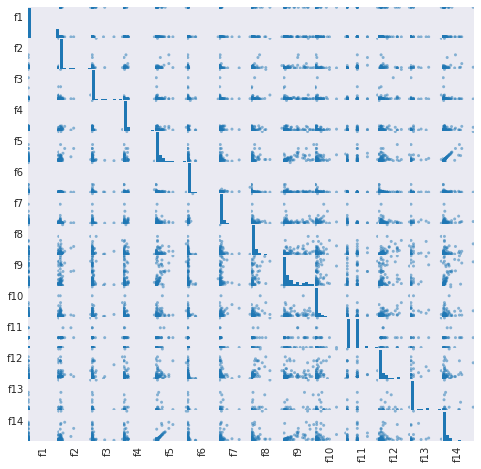

In [117]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [159]:
df = df.select('f1',  'f2',  'f3',  'f4',  'f5',  'f6',  'f7',  'f8',  'f9',   
               'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 
               'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 
               'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 
               'f37', 'f38', 'f39', 'f40')
cols = df.columns
df.printSchema()

root
 |-- f1: integer (nullable = true)
 |-- f2: integer (nullable = true)
 |-- f3: integer (nullable = true)
 |-- f4: integer (nullable = true)
 |-- f5: integer (nullable = true)
 |-- f6: integer (nullable = true)
 |-- f7: integer (nullable = true)
 |-- f8: integer (nullable = true)
 |-- f9: integer (nullable = true)
 |-- f10: integer (nullable = true)
 |-- f11: integer (nullable = true)
 |-- f12: integer (nullable = true)
 |-- f13: integer (nullable = true)
 |-- f14: integer (nullable = true)
 |-- f15: string (nullable = true)
 |-- f16: string (nullable = true)
 |-- f17: string (nullable = true)
 |-- f18: string (nullable = true)
 |-- f19: string (nullable = true)
 |-- f20: string (nullable = true)
 |-- f21: string (nullable = true)
 |-- f22: string (nullable = true)
 |-- f23: string (nullable = true)
 |-- f24: string (nullable = true)
 |-- f25: string (nullable = true)
 |-- f26: string (nullable = true)
 |-- f27: string (nullable = true)
 |-- f28: string (nullable = true)
 |-- f29: 

In [160]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 
                      'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 
                      'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 
                      'f39', 'f40']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stringIndexer.setHandleInvalid("skip")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'f1', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [144]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['f15', 'f16', 'f19', 'f21', 'f22', 
                      'f23', 'f24', 'f25', 'f27', 'f28', 'f29',  
                      'f31', 'f32', 'f37']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    codeIndexer.setHandleInvalid("skip")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'f1', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['f3', 'f9']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [161]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- f1: integer (nullable = true)
 |-- f2: integer (nullable = true)
 |-- f3: integer (nullable = true)
 |-- f4: integer (nullable = true)
 |-- f5: integer (nullable = true)
 |-- f6: integer (nullable = true)
 |-- f7: integer (nullable = true)
 |-- f8: integer (nullable = true)
 |-- f9: integer (nullable = true)
 |-- f10: integer (nullable = true)
 |-- f11: integer (nullable = true)
 |-- f12: integer (nullable = true)
 |-- f13: integer (nullable = true)
 |-- f14: integer (nullable = true)
 |-- f15: string (nullable = true)
 |-- f16: string (nullable = true)
 |-- f17: string (nullable = true)
 |-- f18: string (nullable = true)
 |-- f19: string (nullable = true)
 |-- f20: string (nullable = true)
 |-- f21: string (nullable = true)
 |-- f22: string (nullable = true)
 |-- f23: string (nullable = true)
 |-- f24: string (nullable = true)
 |-- f25: string (nullable = true)
 |-- f26: string (nullable = true)
 |

In [162]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

Py4JJavaError: An error occurred while calling o28800.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 994.0 failed 1 times, most recent failure: Lost task 0.0 in stage 994.0 (TID 1231, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$3: (struct<f15classVec:vector,f16classVec:vector,f17classVec:vector,f18classVec:vector,f19classVec:vector,f20classVec:vector,f21classVec:vector,f22classVec:vector,f23classVec:vector,f24classVec:vector,f25classVec:vector,f26classVec:vector,f27classVec:vector,f28classVec:vector,f29classVec:vector,f30classVec:vector,f31classVec:vector,f32classVec:vector,f33classVec:vector,f34classVec:vector,f35classVec:vector,f36classVec:vector,f37classVec:vector,f38classVec:vector,... 15 more fields>) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.writeFields_28_10$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Values to assemble cannot be null.
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:163)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:146)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:146)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$3.apply(VectorAssembler.scala:99)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$3.apply(VectorAssembler.scala:98)
	... 24 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$3: (struct<f15classVec:vector,f16classVec:vector,f17classVec:vector,f18classVec:vector,f19classVec:vector,f20classVec:vector,f21classVec:vector,f22classVec:vector,f23classVec:vector,f24classVec:vector,f25classVec:vector,f26classVec:vector,f27classVec:vector,f28classVec:vector,f29classVec:vector,f30classVec:vector,f31classVec:vector,f32classVec:vector,f33classVec:vector,f34classVec:vector,f35classVec:vector,f36classVec:vector,f37classVec:vector,f38classVec:vector,... 15 more fields>) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.writeFields_28_10$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
Caused by: org.apache.spark.SparkException: Values to assemble cannot be null.
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:163)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:146)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:146)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$3.apply(VectorAssembler.scala:99)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$3.apply(VectorAssembler.scala:98)
	... 24 more
